<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/trading/perp_basis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Perpetual Futures Basis Strategy 

In this notebook, we're going to explore crypto perpetual futures. Specifically, those traded on FTX.

Holding a perpetual futures positions results in debits or credits to your account, depending on whether you're long or short, and whether the future trades at a premium to its index:
- Perpetual trades at a premium: longs pay shorts
- Perpetual trades at a discount: shorts pay longs

This is a mechanism designed to keep the future tethered to its index. 

In an efficient market, we'd expect this basis (the premium or discount of the future to the index) to converge at the end of the funding period. 

But we'll actually see something quite different to what we'd expect. And this leads us to a nice, simple perpetual futures basis strategy that involves being short perpetuals trading at a premium and long their underlying spot market in equal size and collecting funding credits. 

### Setup and load libraries

In [47]:
# snippet: rw load rwrtools v0.6

# This is an efficient way to: 
  # install necessary packages (both those that you will use directly, and those that are dependencies)
  # load the ones you want to use in your session

# This snippet works by installing as many packages and dependencies using `apt-get` as possible, which is much faster than using install.packages()
# If not loading rsims, this should take around 50 seconds. If loading rsims, it should take around 60s.

# User Instructions:
  # IN MOST USE CASES, YOU WON'T HAVE TO MODIFY ANYTHING - just run this code block as is.
  # Parts of this snippet that the user can modify are highlighted.
  # IF YOU WANT TO USE RSIMS: uncomment the bits that install and load rsims and its dependencies.
  # IF YOU WANT TO USE LIBRARIES THAT AREN'T SPECIFIED IN THE libs_to_load VECTOR BELOW, follow these instructions:
    # specify the libraries you want to use in your research session in the libs_to_load vector.
    # specify as many of the dependecies of these libraries as you like in the other_dependencies vector - the more you are able to specify, the quicker your installation process will be.
    # it doesn't matter if there are double-ups between your other_dependencies and rwRtools_dependencies - the snippet does a check for uniqueness prior to starting the installation process.  
    # it also doesn't matter if you miss some dependencies as these will be picked up during the installation process (albeit they'll be installed slower than they otherwise would).
  # IF SOMETHING GOES WRONG: 
    # ... with installing libraries other than rsims and rwRtools, debug the install process by inspecting the msg2 object, which holds the output of the apt install process.
    # ... with the installation of rsims or rwRtools, change the calls to p_load_current_gh such that dependencies = TRUE (this will be much slower, but will catch any libraries 
      # that were missed upstream, for example if rwRtools had dependencies added later that aren't captured in the default list.)
    # if you get stuck, ask on Slack!

# How to figure out a package's dependencies? Use available.packages(). Example for getting the packages that patchwork depends upon:
# pkgs <- available.packages()
# pkgs["patchwork","Imports"]

# install pacman the old fashioned way - isn't listed as an ubuntu package
install.packages('pacman')

# rwRtools dependencies (install but don't load) 
rwRtools_dependencies <- c(
  "pillar", "tibble", "rlang", "httr", "iterators", "zoo", "R.methodsS3", "callr", "foreach", 
  "xts", "stringi", "Rcpp", "R.oo", "gargle", "googleAuthR", "glue", 
  "googleCloudStorageR", "R.utils", "feather", "lubridate", "readr", "stringr", 
  "dplyr", "purrr", "magrittr", "TTR", "doParallel"
)

# libraries to load (install and load) 
##################################################
##### USER ADDS LIBRARIES TO BE LOADED HERE ######
##################################################
libs_to_load <- c("dplyr", "tidyr", "ggplot2", "lubridate", "purrr", "glue", "stringr", "patchwork", "slider")

# dependencies (install but don't load) 
##################################################
##### USER ADDS DEPENDENCIES HERE ################
##################################################
other_dependencies <- c(
  "generics", "lifecycle", "R6", "rlang", "tidyselect", "vctrs", "pillar", 
  "ellipsis", "digest", "gtable", "isoband", "MASS", "mgcv", "scales", "withr", 
  "stringi", "iterators", "R.methodsS3", "openssl", "foreach", "xts", 
  "R.oo", "RcppArmadillo", "slam", "timeDate", "cccp", "Rglpk", "timeSeries",
  "tibble", "tidyr", "here", "roll", "Rcpp"
)

##################################################
#### UNCOMMENT NEXT TWO LINES IF USING RSIMS #####
##################################################
# rsims_dependencies <- c("ggplot2", "lubridate", "roll", "Rcpp")
# other_dependencies <- c(other_dependencies, rsims_dependencies)

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", unique(c(libs_to_load, other_dependencies, rwRtools_dependencies)), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rwRtools from GH (sans dependencies)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = FALSE)

# install and load rsims from GH (sans dependencies) 
###################################################
###### UNCOMMENT NEXT LINE IF USING RSIMS #########
###################################################
# pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = FALSE)

# output messages from install - optional, for debugging 
#########################################################
## UNCOMMENT NEXT LINE TO DEBUG INSTALL PROCESS #########
#########################################################
# msg2

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [14]:
rwRtools::rwlab_data_auth()

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-0l5tra7gl2i20iftqangp7iskte4f3s0.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AWgavdehhzlSlLdFKPZDIoBrgKz4lq6YtL7mmse2e8MHIyQi9qL86VdEz6w


### Get FTX perpetual funding history

In [15]:
rwRtools:::transfer_lab_object(
      pod = "Crypto",
      object = "ftx_perpetual_funding_rates.feather",
      path = "."
)

funding <- feather::read_feather('ftx_perpetual_funding_rates.feather')
funding <- funding %>% mutate(date = lubridate::as_datetime(date))
tail(funding)

ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ./ftx_perpetual_funding_rates.fe…





File successfully transferred


[1] TRUE

ticker,date,rate
<chr>,<dttm>,<dbl>
ZRX-PERP,2022-11-11 19:00:00,-0.000307
ZRX-PERP,2022-11-11 20:00:00,-0.000499
ZRX-PERP,2022-11-11 21:00:00,-0.000459
ZRX-PERP,2022-11-11 22:00:00,-0.000500
ZRX-PERP,2022-11-11 23:00:00,-0.000535
ZRX-PERP,2022-11-12 00:00:00,-0.000681


Plot some funding rate time series

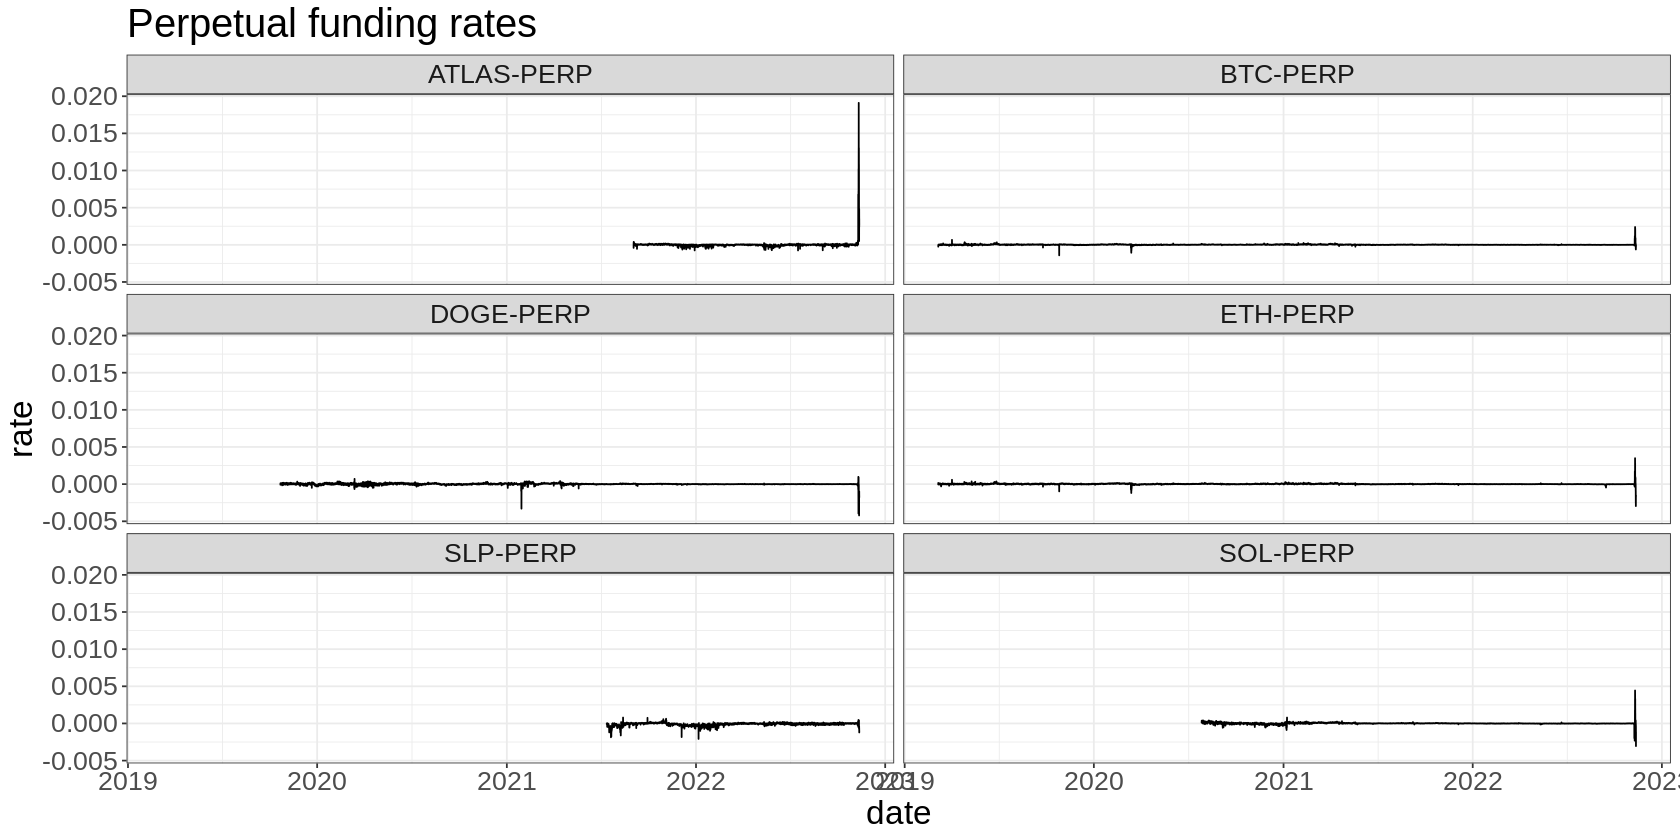

In [16]:
funding %>%
  filter(ticker %in% c("BTC-PERP", "ETH-PERP", "SOL-PERP", "DOGE-PERP", "SLP-PERP", "ATLAS-PERP")) %>%
  group_by(ticker) %>%
  ggplot(aes(x = date, y = rate)) +
    geom_line() +
    facet_wrap(~ticker, ncol = 2) +
    labs(title = "Perpetual funding rates")

### Basis analysis

If the perpetual futures markets were entirely efficient, we'd expect to see the basis converge at the end of the funding period. 

But is that what we actually see? Let's find out...

First, it's worth making explicit that we can use the funding rate as a proxy for the basis itself, since the funding rate is calculated from the magnitude of the discount/premium that the futures trade at relative to the index (ie the basis itself). 

One quick way to explore the time series dynamics of the basis is to plot the autocorrelation of the funding rate.

*Autocorrelation of a time series is the correlation of the series with various lags of itself.*

For example the autocorrelation at lag 1 is the correlation of the series with itself lagged by one period. Autocorrelation at lag 2 is the correlation of the series with itself lagged by two periods. And so on. 

*If a time series shows autocorrelation, then it follows that past values of the series can be used to predict future values of the series.* 

Partial autocorrelation is the relationship between a time series and the lagged time series with the relationship of intervening lags removed. It essentially represents the correlation with each lag that isn't explained by previous lags. 

In an efficient perpetual future, we'd expect the funding rate to *not* be autocorrelated. The autocorrelations and partial autocorrelations at various lags should look entirely random. 

Some helper functions for making nice plots:


In [17]:
# return dataframe of lags and acf values
tidy_acf <- function(x, max_lags = 20) {
  acfs <- x %>%
    acf(lag.max = max_lags, plot = FALSE)

  data.frame(
    lag = factor(acfs$lag),
    acf = acfs$acf
  )
}

# return dataframe of lags and pacf values
tidy_pacf <- function(x, max_lags = 20) {
  pacfs <- x %>%
    pacf(lag.max = max_lags, plot = FALSE)

  data.frame(
    lag = factor(pacfs$lag),
    pacf = pacfs$acf
  )
}

# signifiance levels based on sample size
significance <- function(n) {
  qnorm((1 + 0.95)/2)/sqrt(n)
}

# plot acf with pacf inset
plot_acf <- function(funding, perp, max_lags) {
  sig <- funding %>%
    filter(ticker == perp) %>%
    pull(rate) %>%
    length() %>%
    significance()

  acf_plot <- funding %>%
    filter(ticker == perp) %>%
    pull(rate) %>%
    tidy_acf(max_lags) %>%
    ggplot(aes(x = lag, y = acf)) +
      geom_point(colour = "blue") +
      geom_segment(aes(xend = lag, yend = 0)) +
      geom_hline(yintercept = sig, colour = 'blue', linetype = 'dashed') +
      geom_hline(yintercept = -sig, colour = 'blue', linetype = 'dashed') +
      labs(
        title = glue("ACF of {perp} funding rate")
      )
  
  pacf_plot <- funding %>%
    filter(ticker == perp) %>%
    pull(rate) %>%
    tidy_pacf(min(max_lags, 10)) %>%
    ggplot(aes(x = lag, y = pacf)) +
      geom_point(colour = "blue") +
      geom_segment(aes(xend = lag, yend = 0)) +
      geom_hline(yintercept = sig, colour = 'blue', linetype = 'dashed') +
      geom_hline(yintercept = -sig, colour = 'blue', linetype = 'dashed') +
      labs(
        title = glue("PACF")
      )

  acf_plot + 
    inset_element(pacf_plot, left = 0.5, bottom = 0.5, right = 1, top = 1)
}

ACF of funding rate for various PERPs with PACF to fewer lags inset:

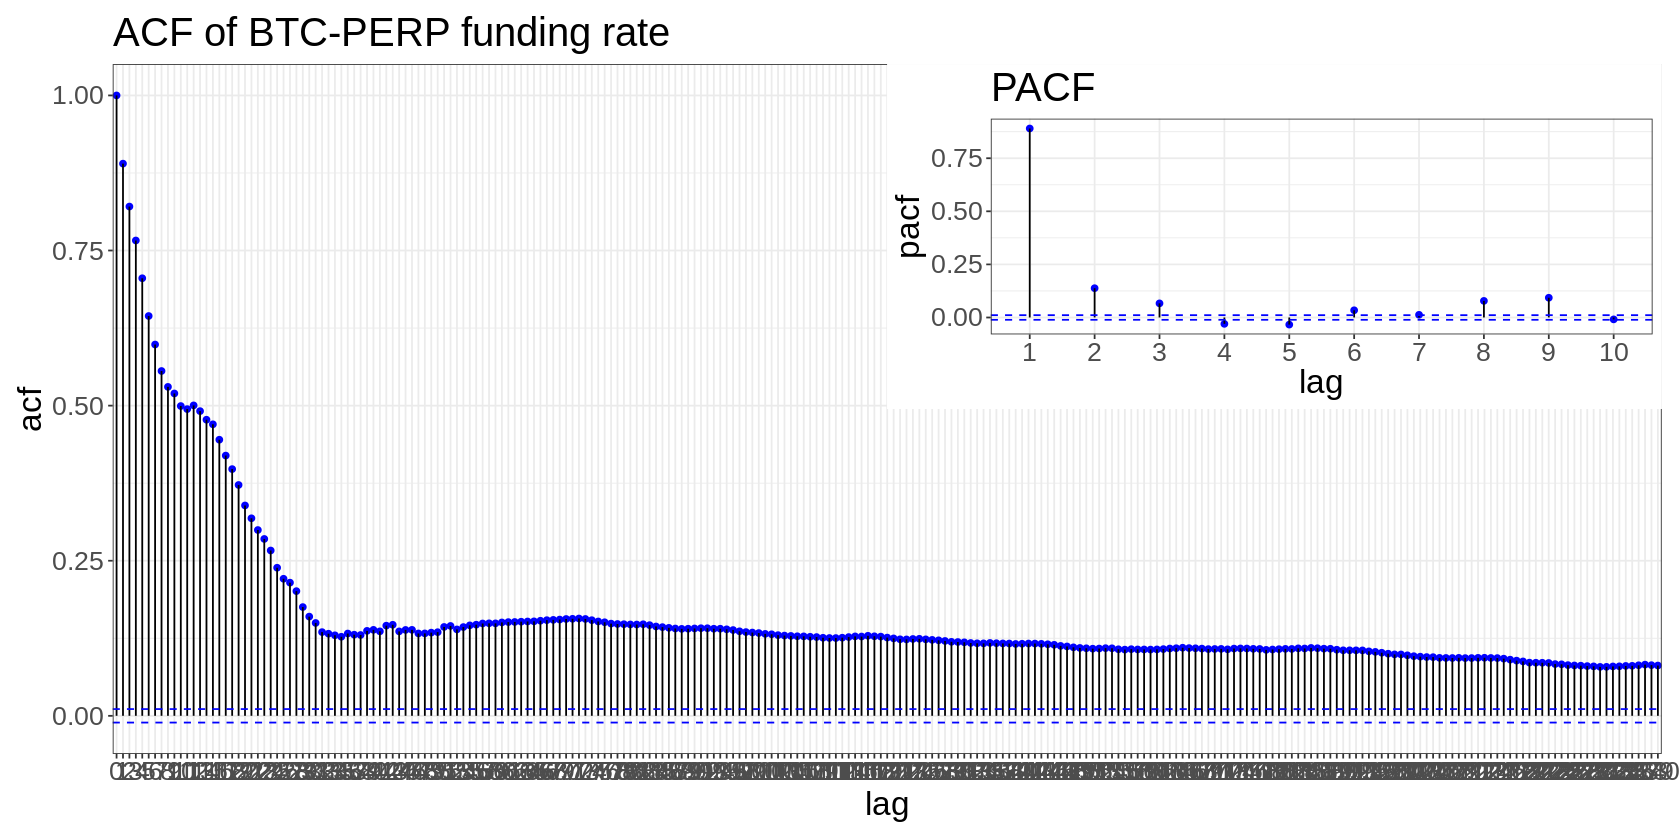

In [18]:
perp <- "BTC-PERP"
max_lags <- 240

funding %>%
  plot_acf(perp, max_lags)

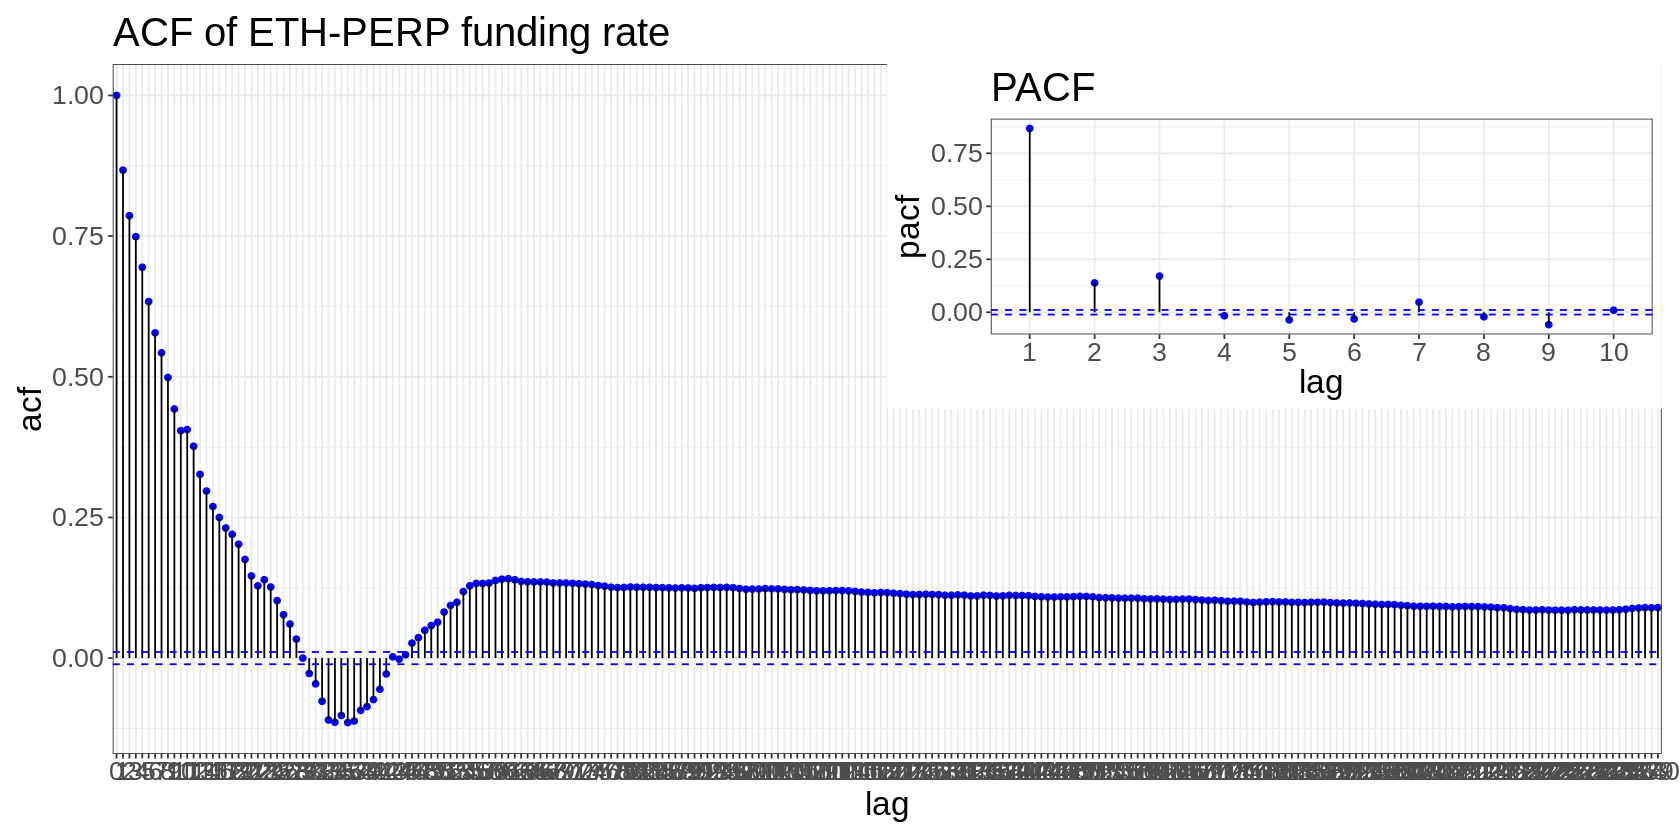

In [19]:
funding %>%
  plot_acf("ETH-PERP", max_lags)

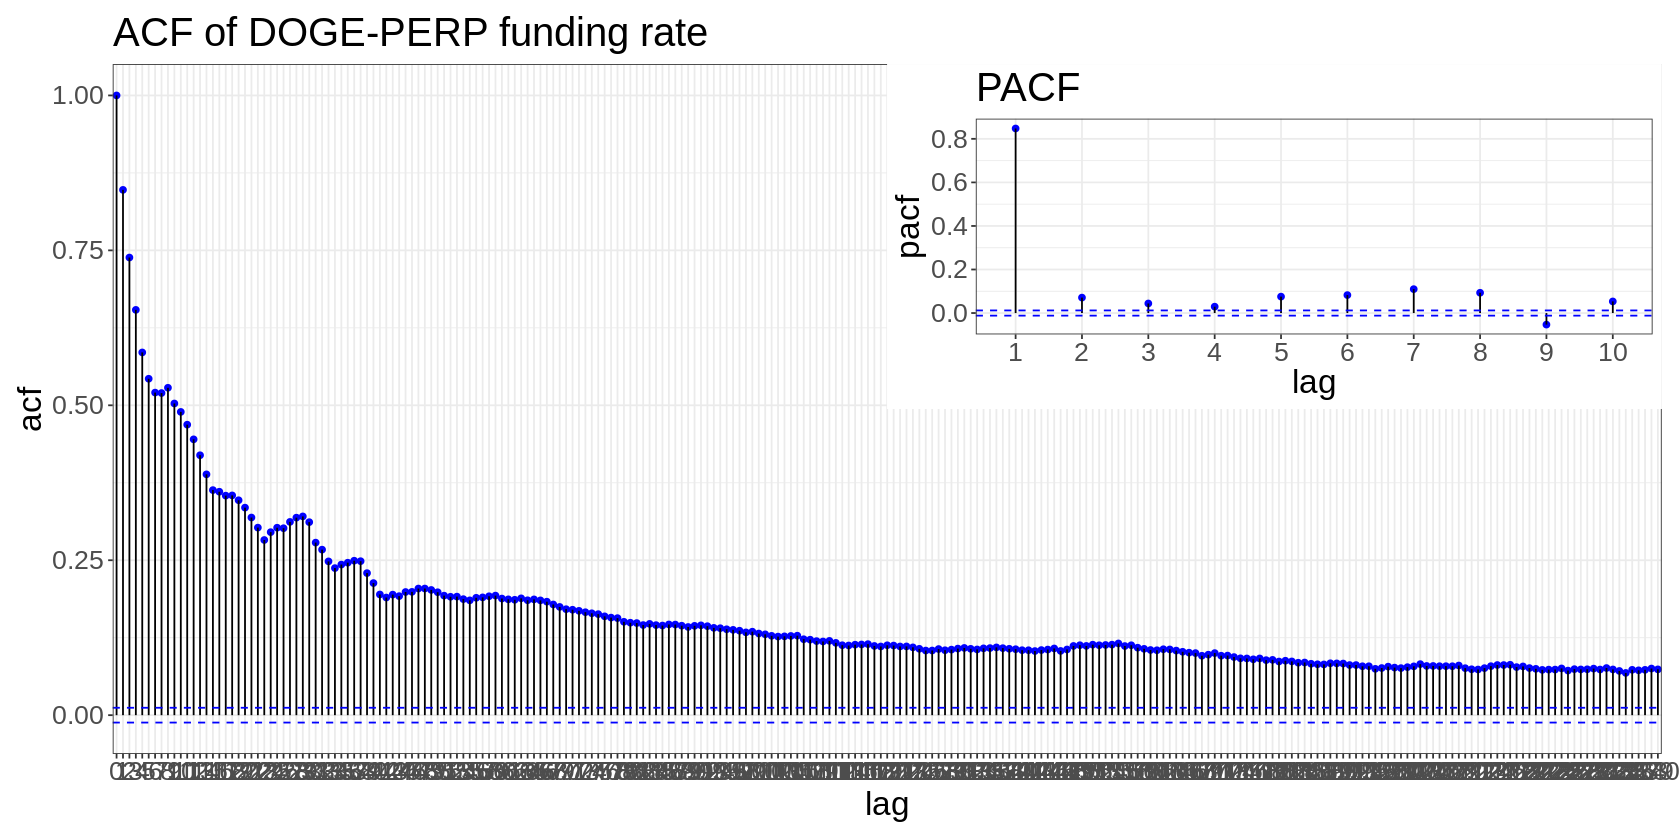

In [20]:
funding %>%
  plot_acf("DOGE-PERP", max_lags)

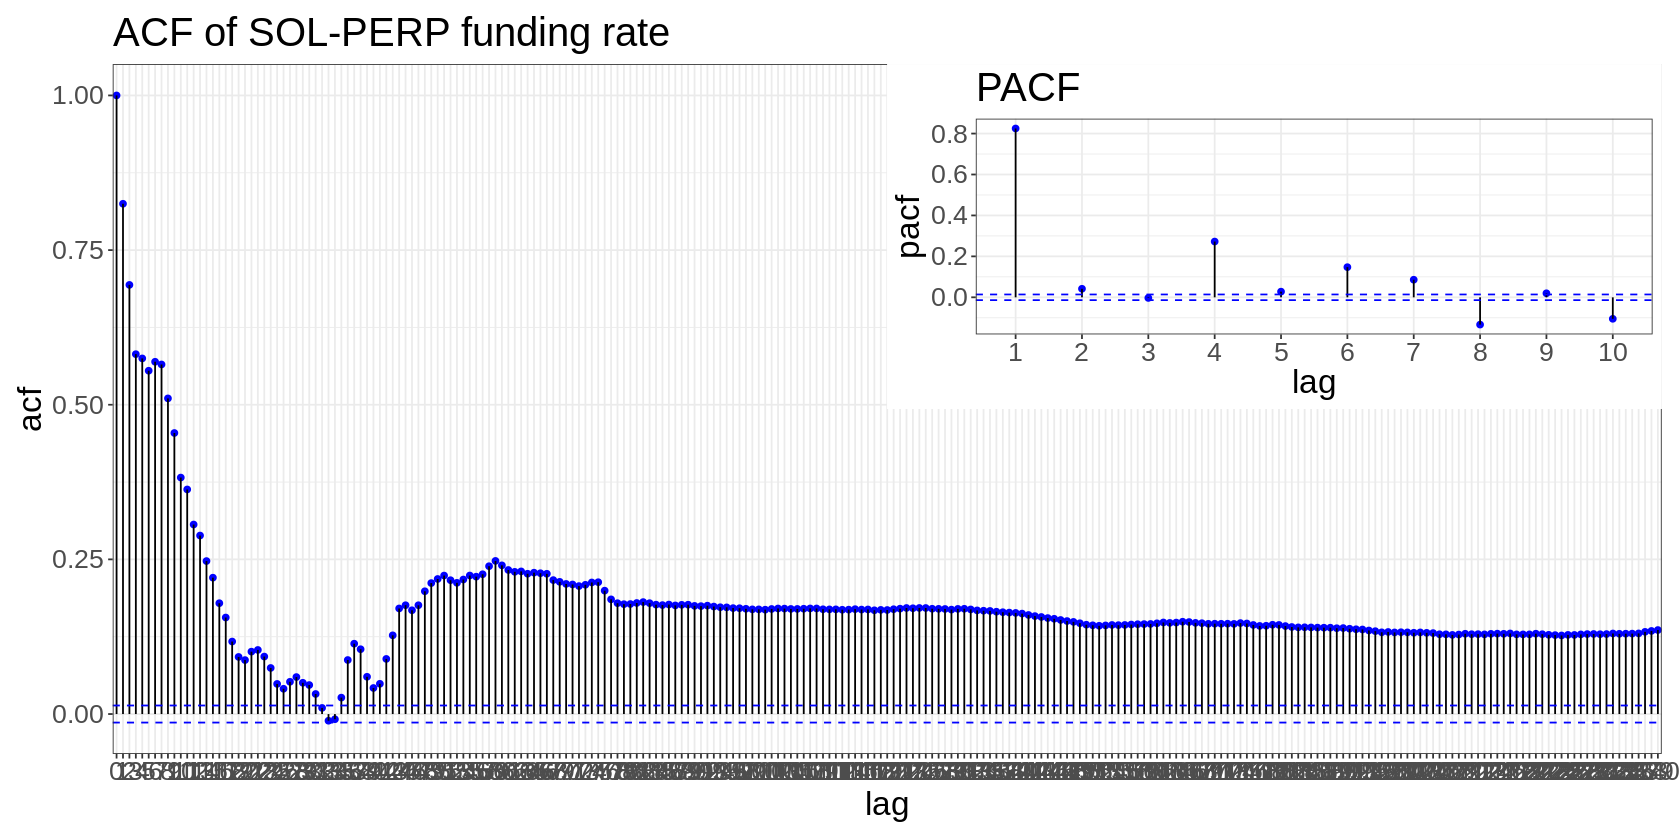

In [21]:
funding %>%
  plot_acf("SOL-PERP", max_lags)

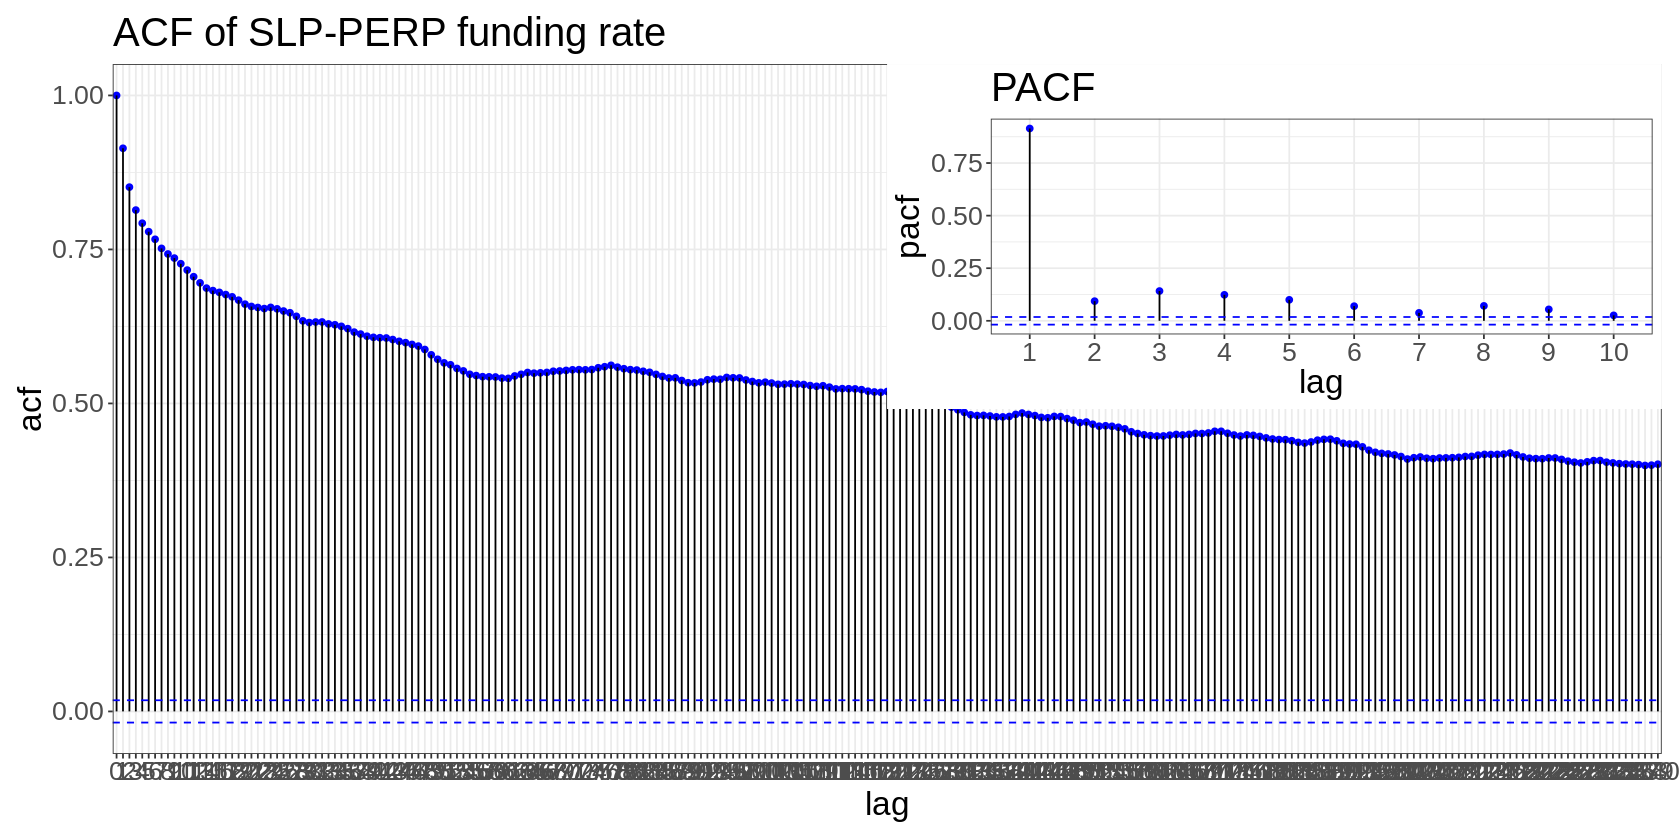

In [22]:
funding %>%
  plot_acf("SLP-PERP", max_lags)

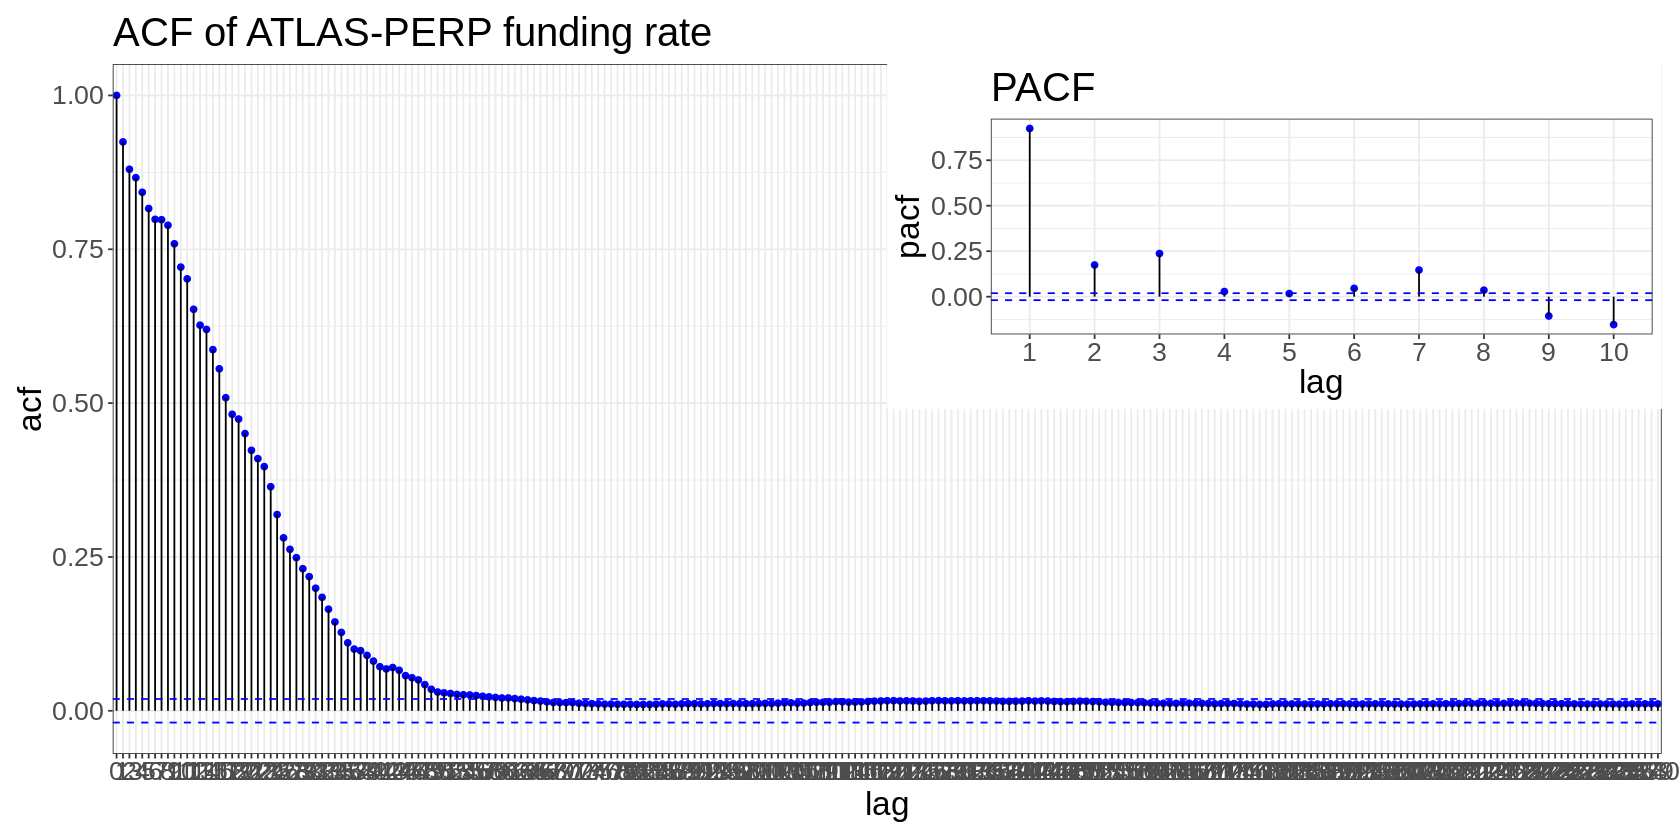

In [23]:
funding %>%
  plot_acf("ATLAS-PERP", max_lags)

We see the opposite of what we would expect in an efficient market! The ACF plots show that the funding rate is generally quite sticky - that is, it's positively correlated with past values of itself. The PACF plots decay a lot faster than the ACF plots, which is exactly what you'd expect, but they also suggest that even when you control for the relationship with lag-1 of the time series, there is still some relationship with lag-2, lag-3 etc. 

This suggests that while the last hour's funding rate is a decent predictor of the next hour's funding rate, you could include information from prior hours and make better predictions (potentially). 

For comparison, here's how ACF and PACF plots look for completley random data:

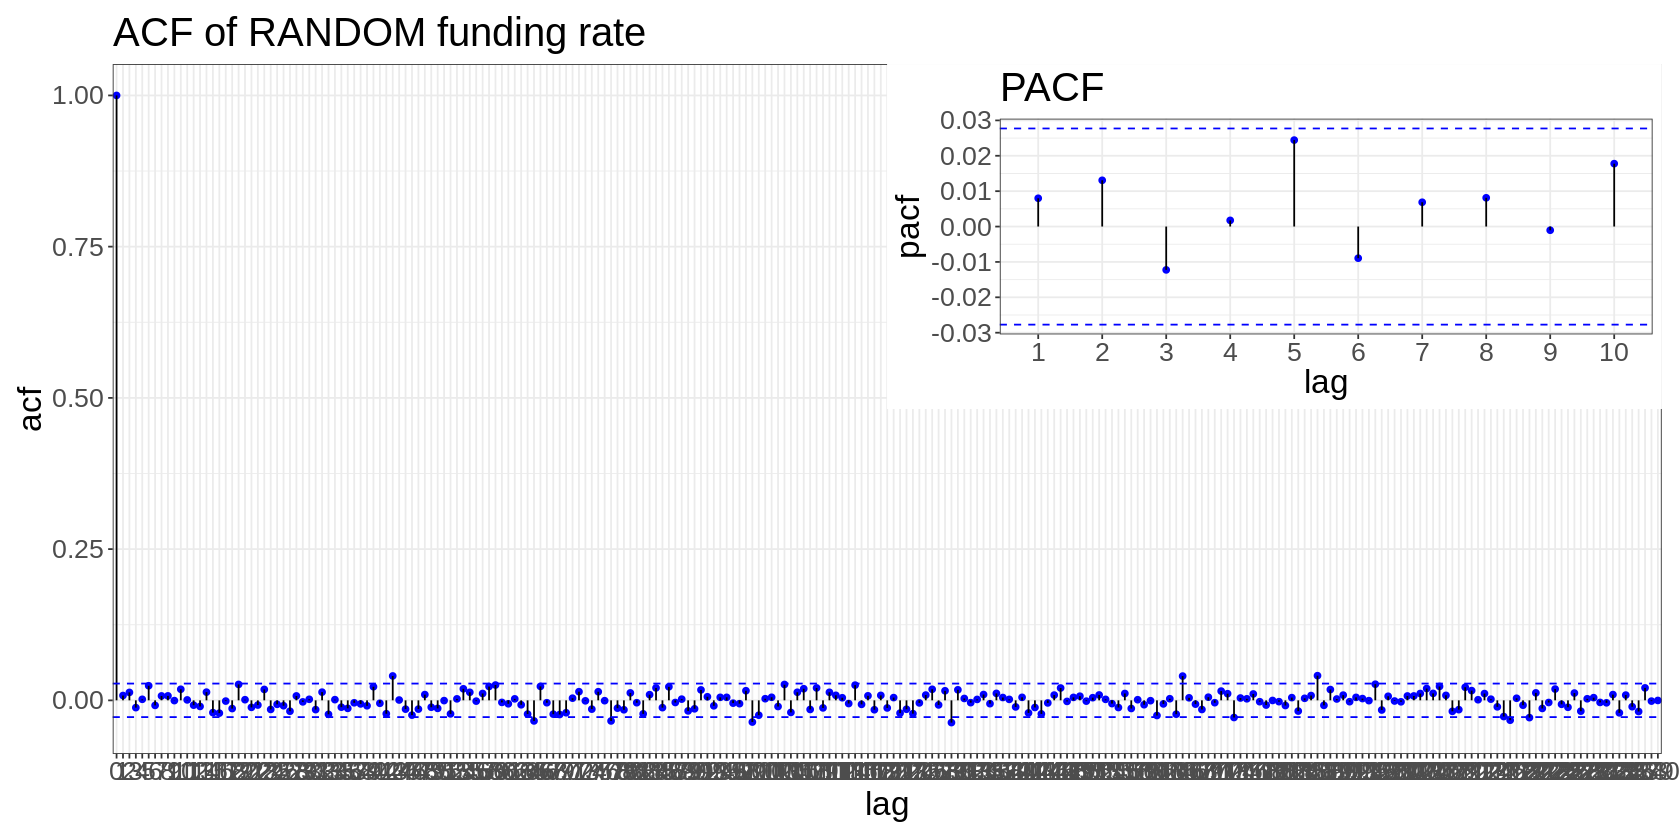

In [24]:
data.frame(ticker = "RANDOM", rate = rnorm(5000)) %>%
  plot_acf("RANDOM", max_lags)

Vastly different to the ACF and PACF plots of our perpetual funding rates. 

Above we looked at hourly funding. Might funding also be "sticky" when aggregated to a daily timescale? To investigate, we'll sum the hourly funding rates for each ticker for each day:

In [25]:
daily_funding <- funding %>% 
  mutate(day = date(date), hour = hour(date)) %>% 
  group_by(ticker, day) %>% 
  summarise(rate = sum(rate, na.rm = TRUE))

head(daily_funding)

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,day,rate
<chr>,<date>,<dbl>
1INCH-PERP,2020-12-25,0.000434
1INCH-PERP,2020-12-26,-0.002614
1INCH-PERP,2020-12-27,0.002228
1INCH-PERP,2020-12-28,0.003072
1INCH-PERP,2020-12-29,0.002202
1INCH-PERP,2020-12-30,0.001630


ACF and PACF of daily funding rates for various perpetuals:

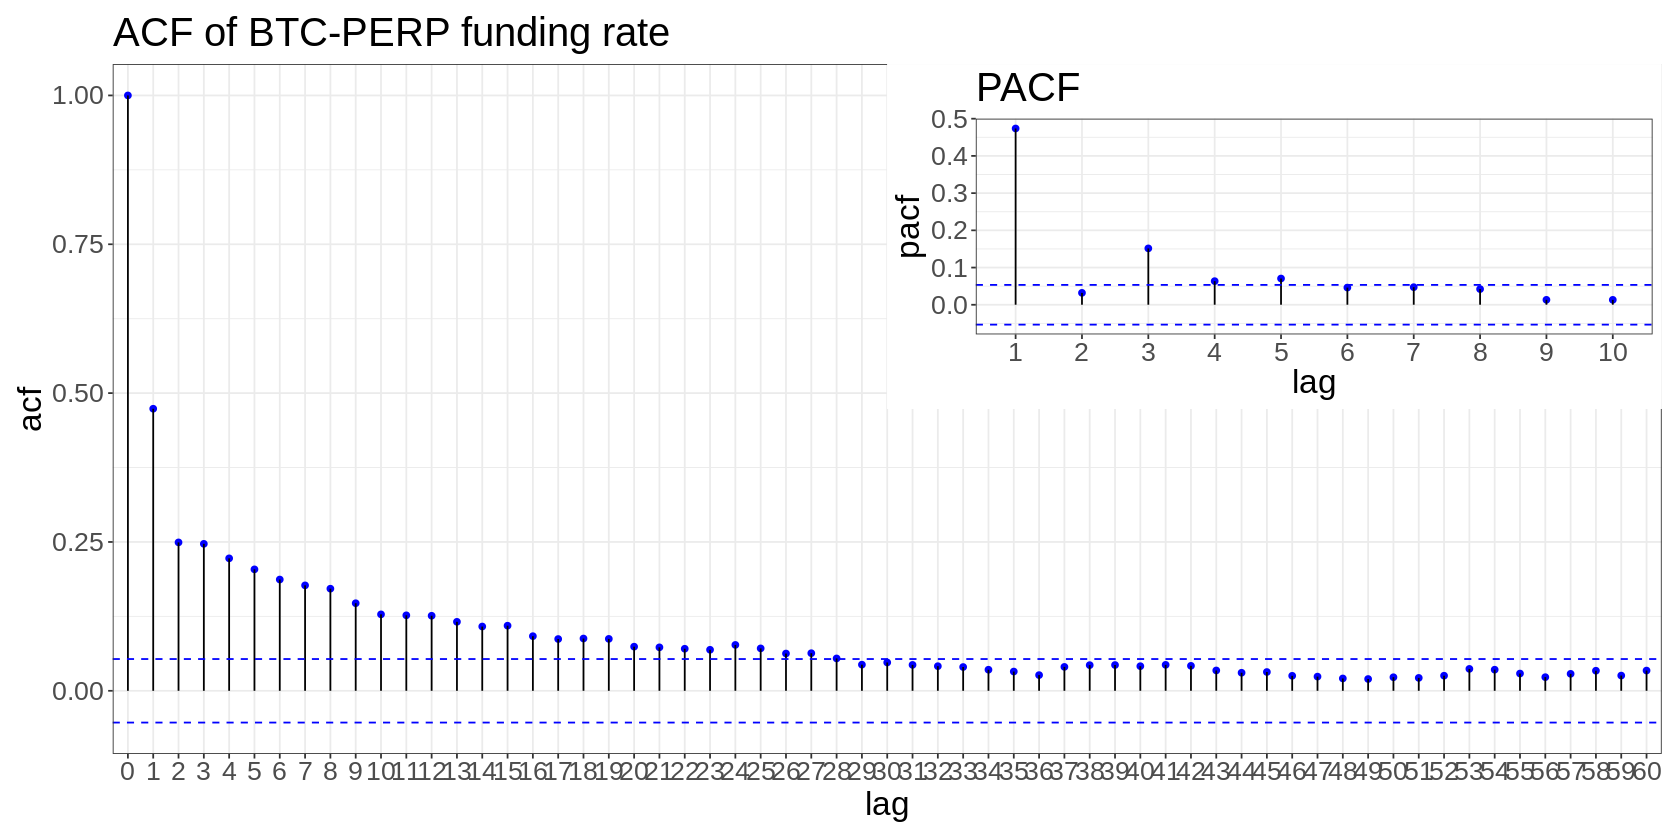

In [26]:
max_lags <- 60 
daily_funding %>%
  plot_acf("BTC-PERP", max_lags = max_lags)

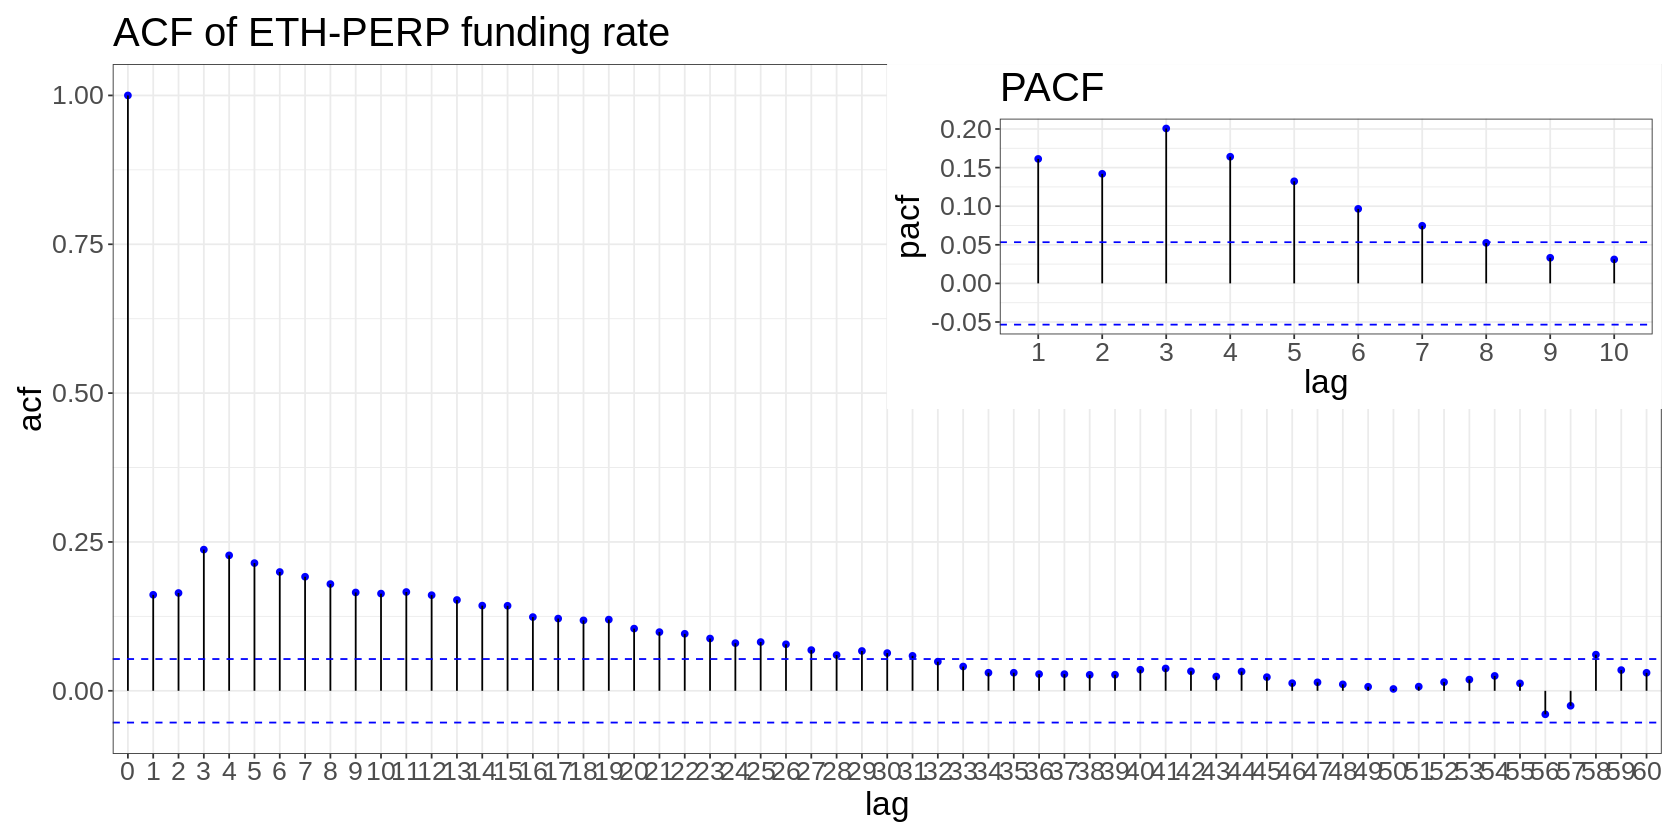

In [27]:
max_lags <- 60 
daily_funding %>%
  plot_acf("ETH-PERP", max_lags = max_lags)

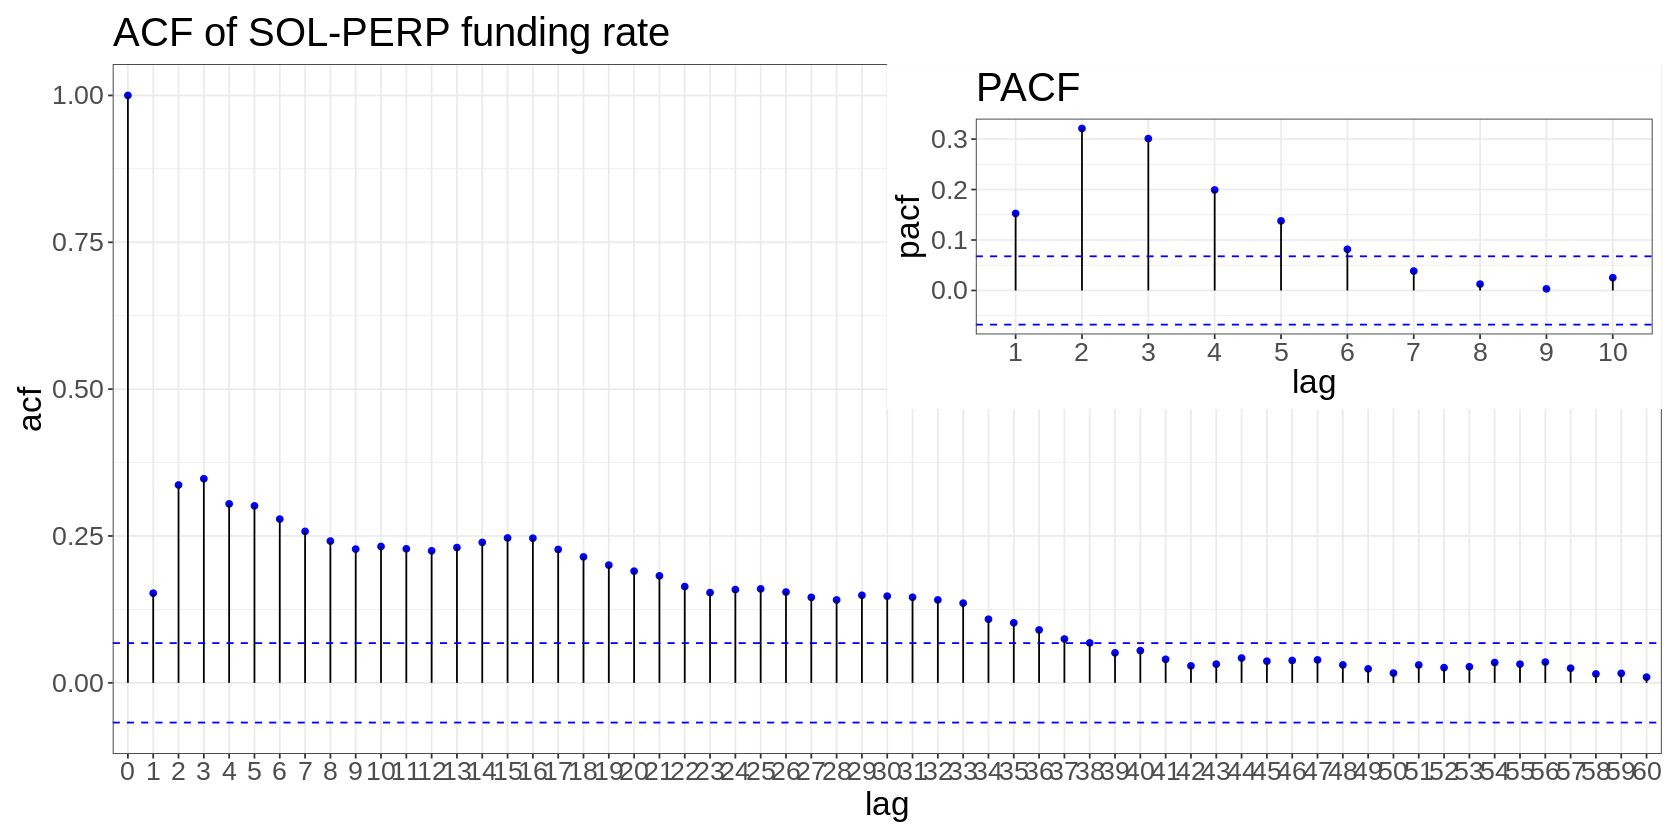

In [28]:
max_lags <- 60 
daily_funding %>%
  plot_acf("SOL-PERP", max_lags = max_lags)

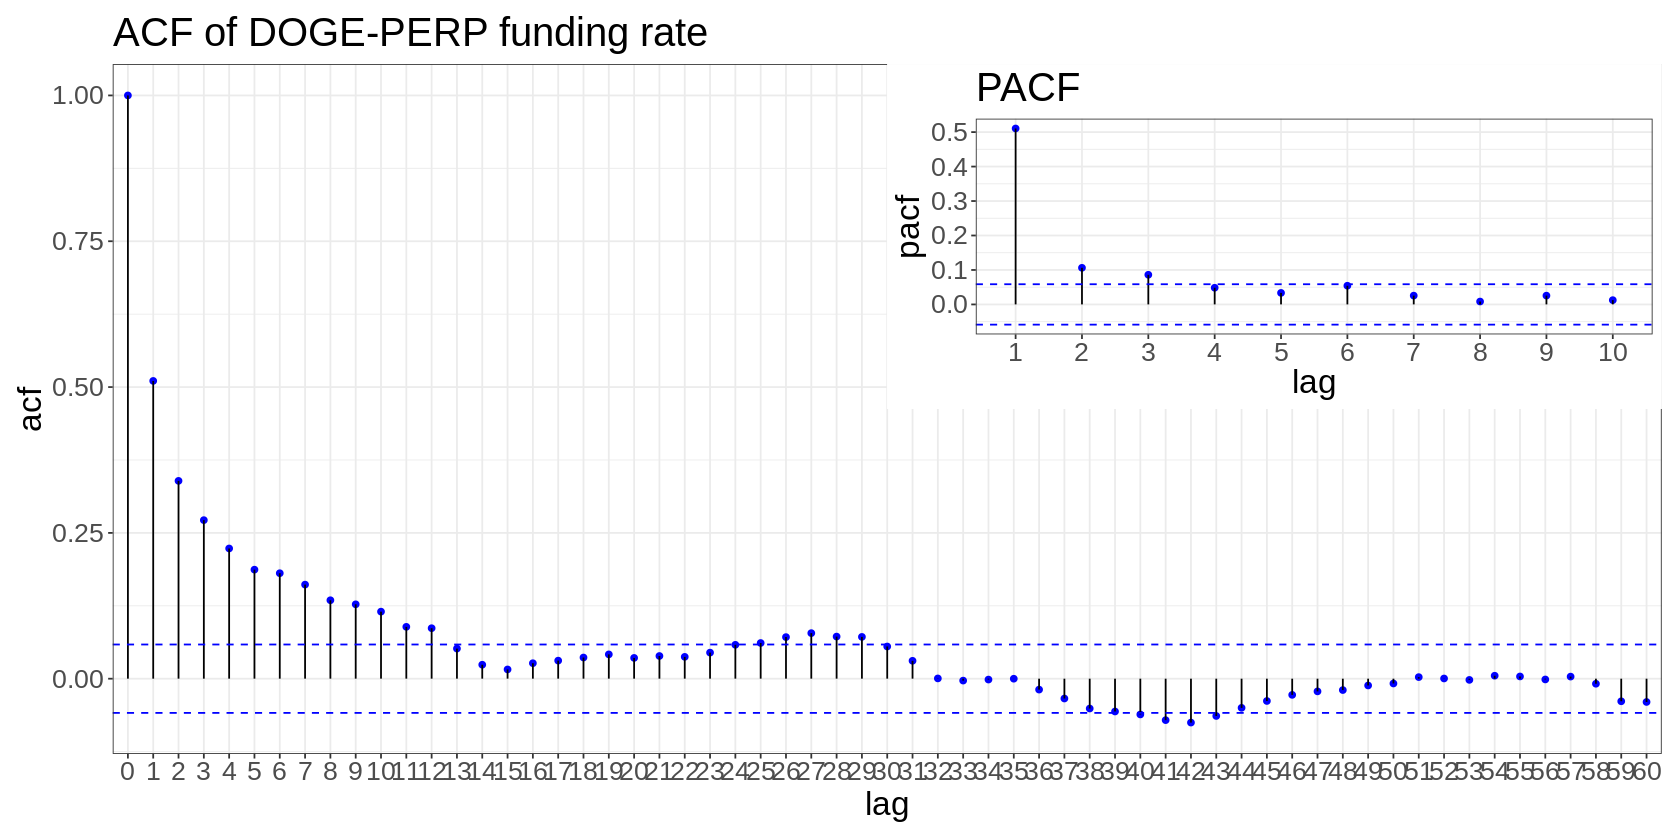

In [29]:
max_lags <- 60 
daily_funding %>%
  plot_acf("DOGE-PERP", max_lags = max_lags)

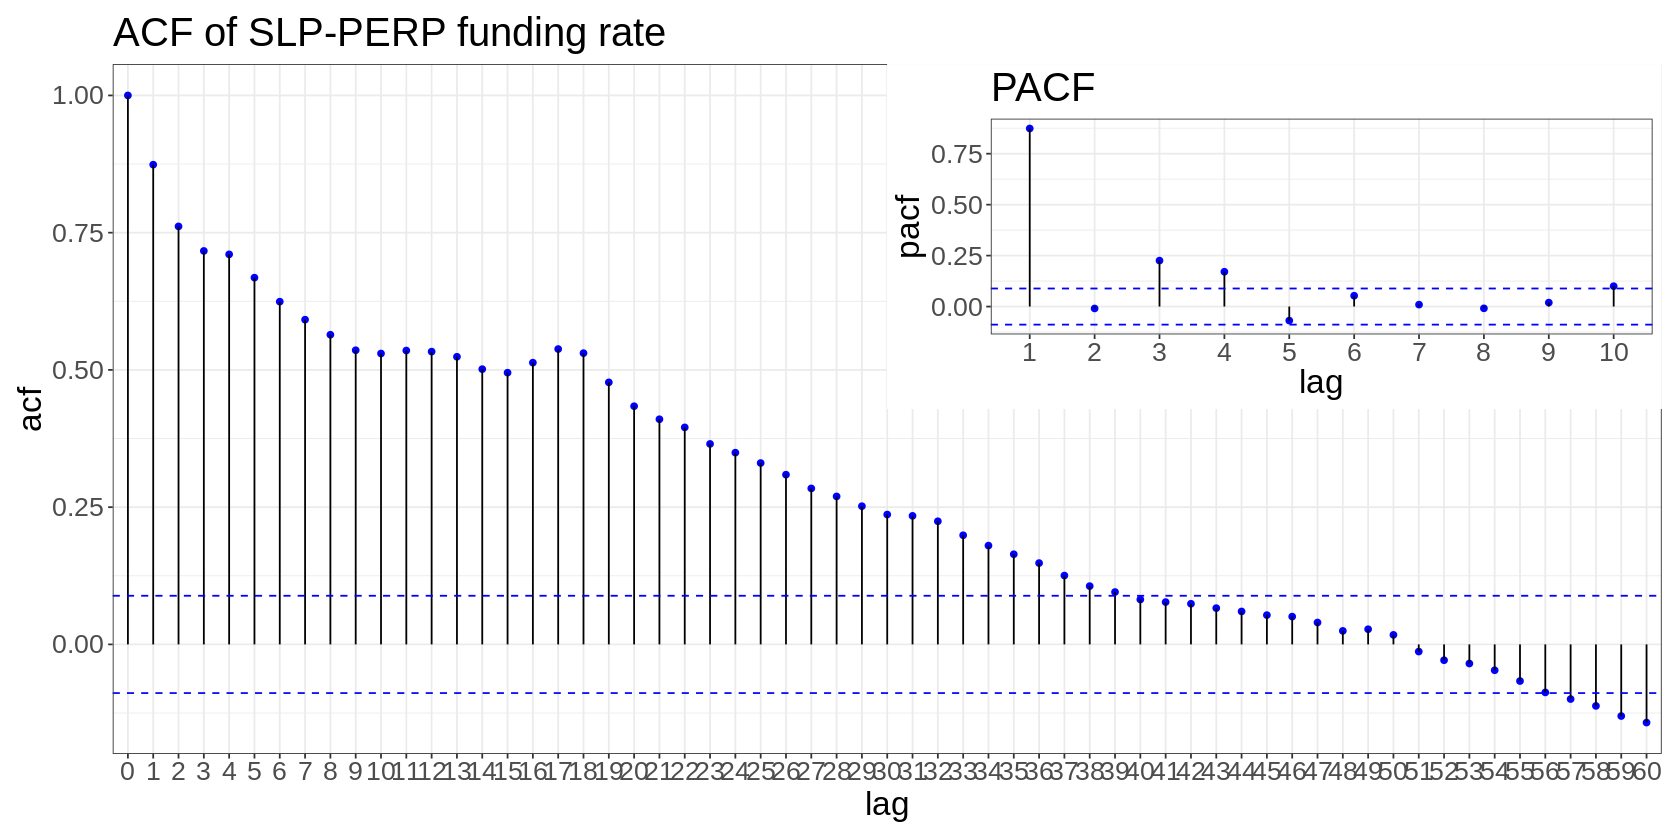

In [30]:
max_lags <- 60 
daily_funding %>%
  plot_acf("SLP-PERP", max_lags = max_lags)

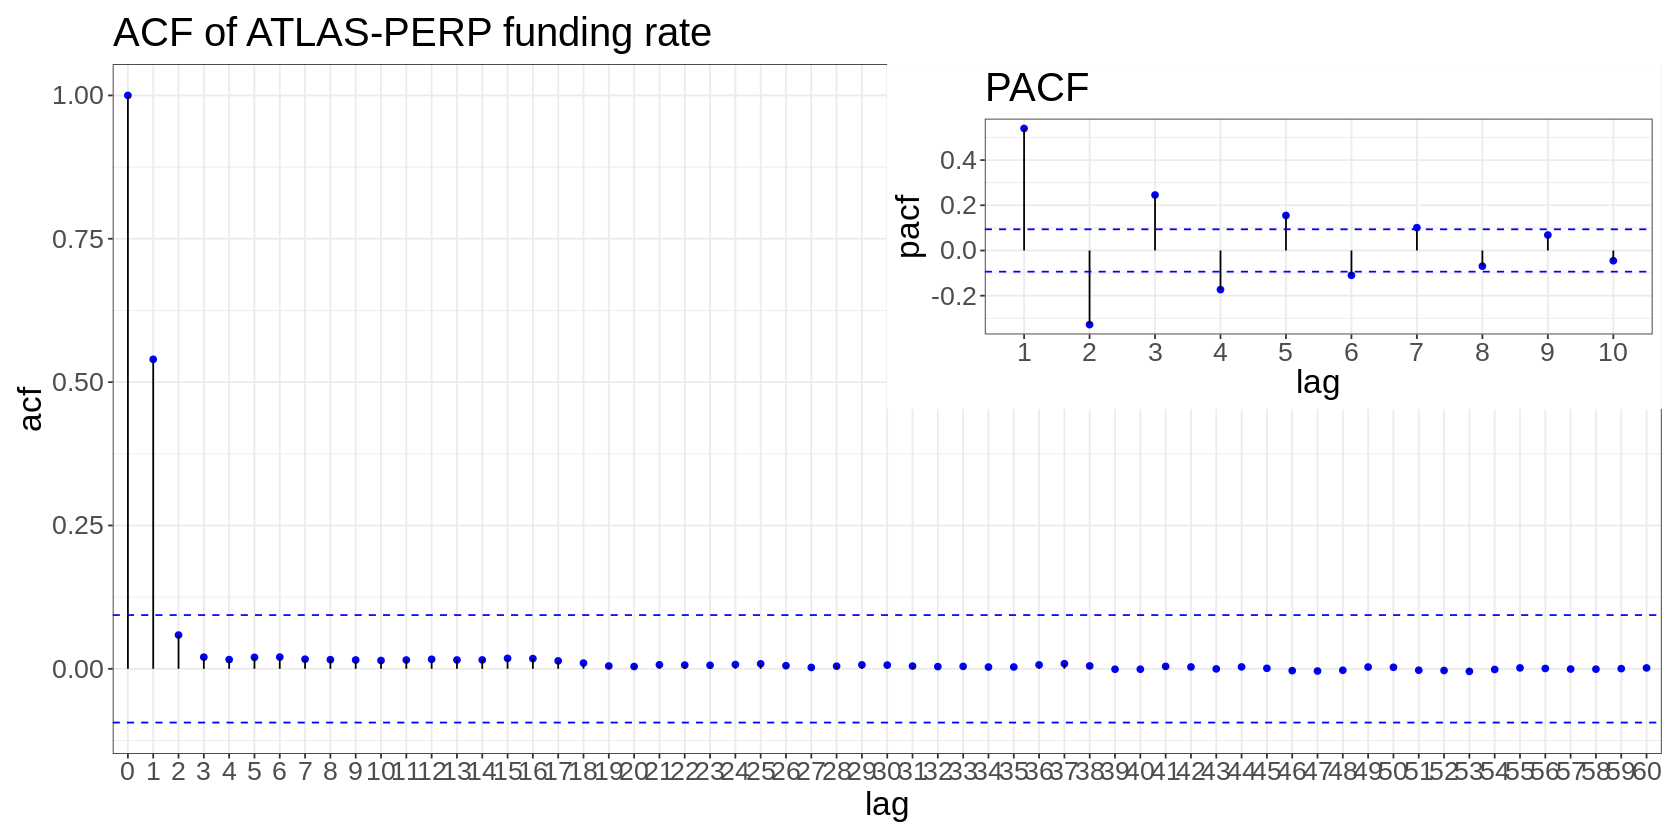

In [31]:
max_lags <- 60 
daily_funding %>%
  plot_acf("ATLAS-PERP", max_lags = max_lags)

We see significant autocorrelation for daily funding rate as well. 

The PACF plots of daily funding suggest that funding from even 3-4 days previous is a helpful predictor. In particular, we see daily funding highly correlated with yesterday's funding and positively (but much less) correlated with funding 3-4 days previous. 

In short, the basis seems to be predictable over time scales that we're probably interested in from a trading perspective. 

> What time scale are we actually interested in trading over?

Let's explore that idea of a "trading horizon". Assuming we had a reasonable prediction of future funding rates, what sort of hold time would we need in order to accrue enough funding to overcome trading costs?

Assume we would harness funding by being short the perpetual and long the spot. This results in a position that isn't exposed to movements of the underlying (it's "delta-neutral") but does accrue funding. 

Assume we pay 0.1% on both legs on the way in and on the way out of the trade.

**A small note:**  
"Isn't exposed to movements of the underlying" isn't exactly correct... our delta-neutral position is still exposed to *relative* movements between the perp and the spot. That is, movements in the basis itself. Specifically, an increase in the basis will result in a mark-to-market loss on the position, while a decrease in the basis will result in the opposite. We'll see this in action when we simulate the strategy we end up building. 

Let's look at the magnitude of average daily funding rates we've seen in the past. First, the average annualised funding rate of all coins:

In [32]:
avg_daily_funding <- daily_funding %>%
  group_by(ticker) %>%
  summarise(avg_funding = mean(rate, na.rm = TRUE))

# average daily funding rate of all coins
all_coins_avg <- avg_daily_funding %>% pull(avg_funding) %>% mean(na.rm = TRUE)
all_coins_avg*100*365

# average daily funding rate of all coins with positive funding on average:
all_positive_avg <- avg_daily_funding %>% filter(avg_funding > 0) %>% pull(avg_funding) %>% mean(na.rm = TRUE)
all_positive_avg*100*365

[1] -8.573856

[1] 34.58778

Individual coins:

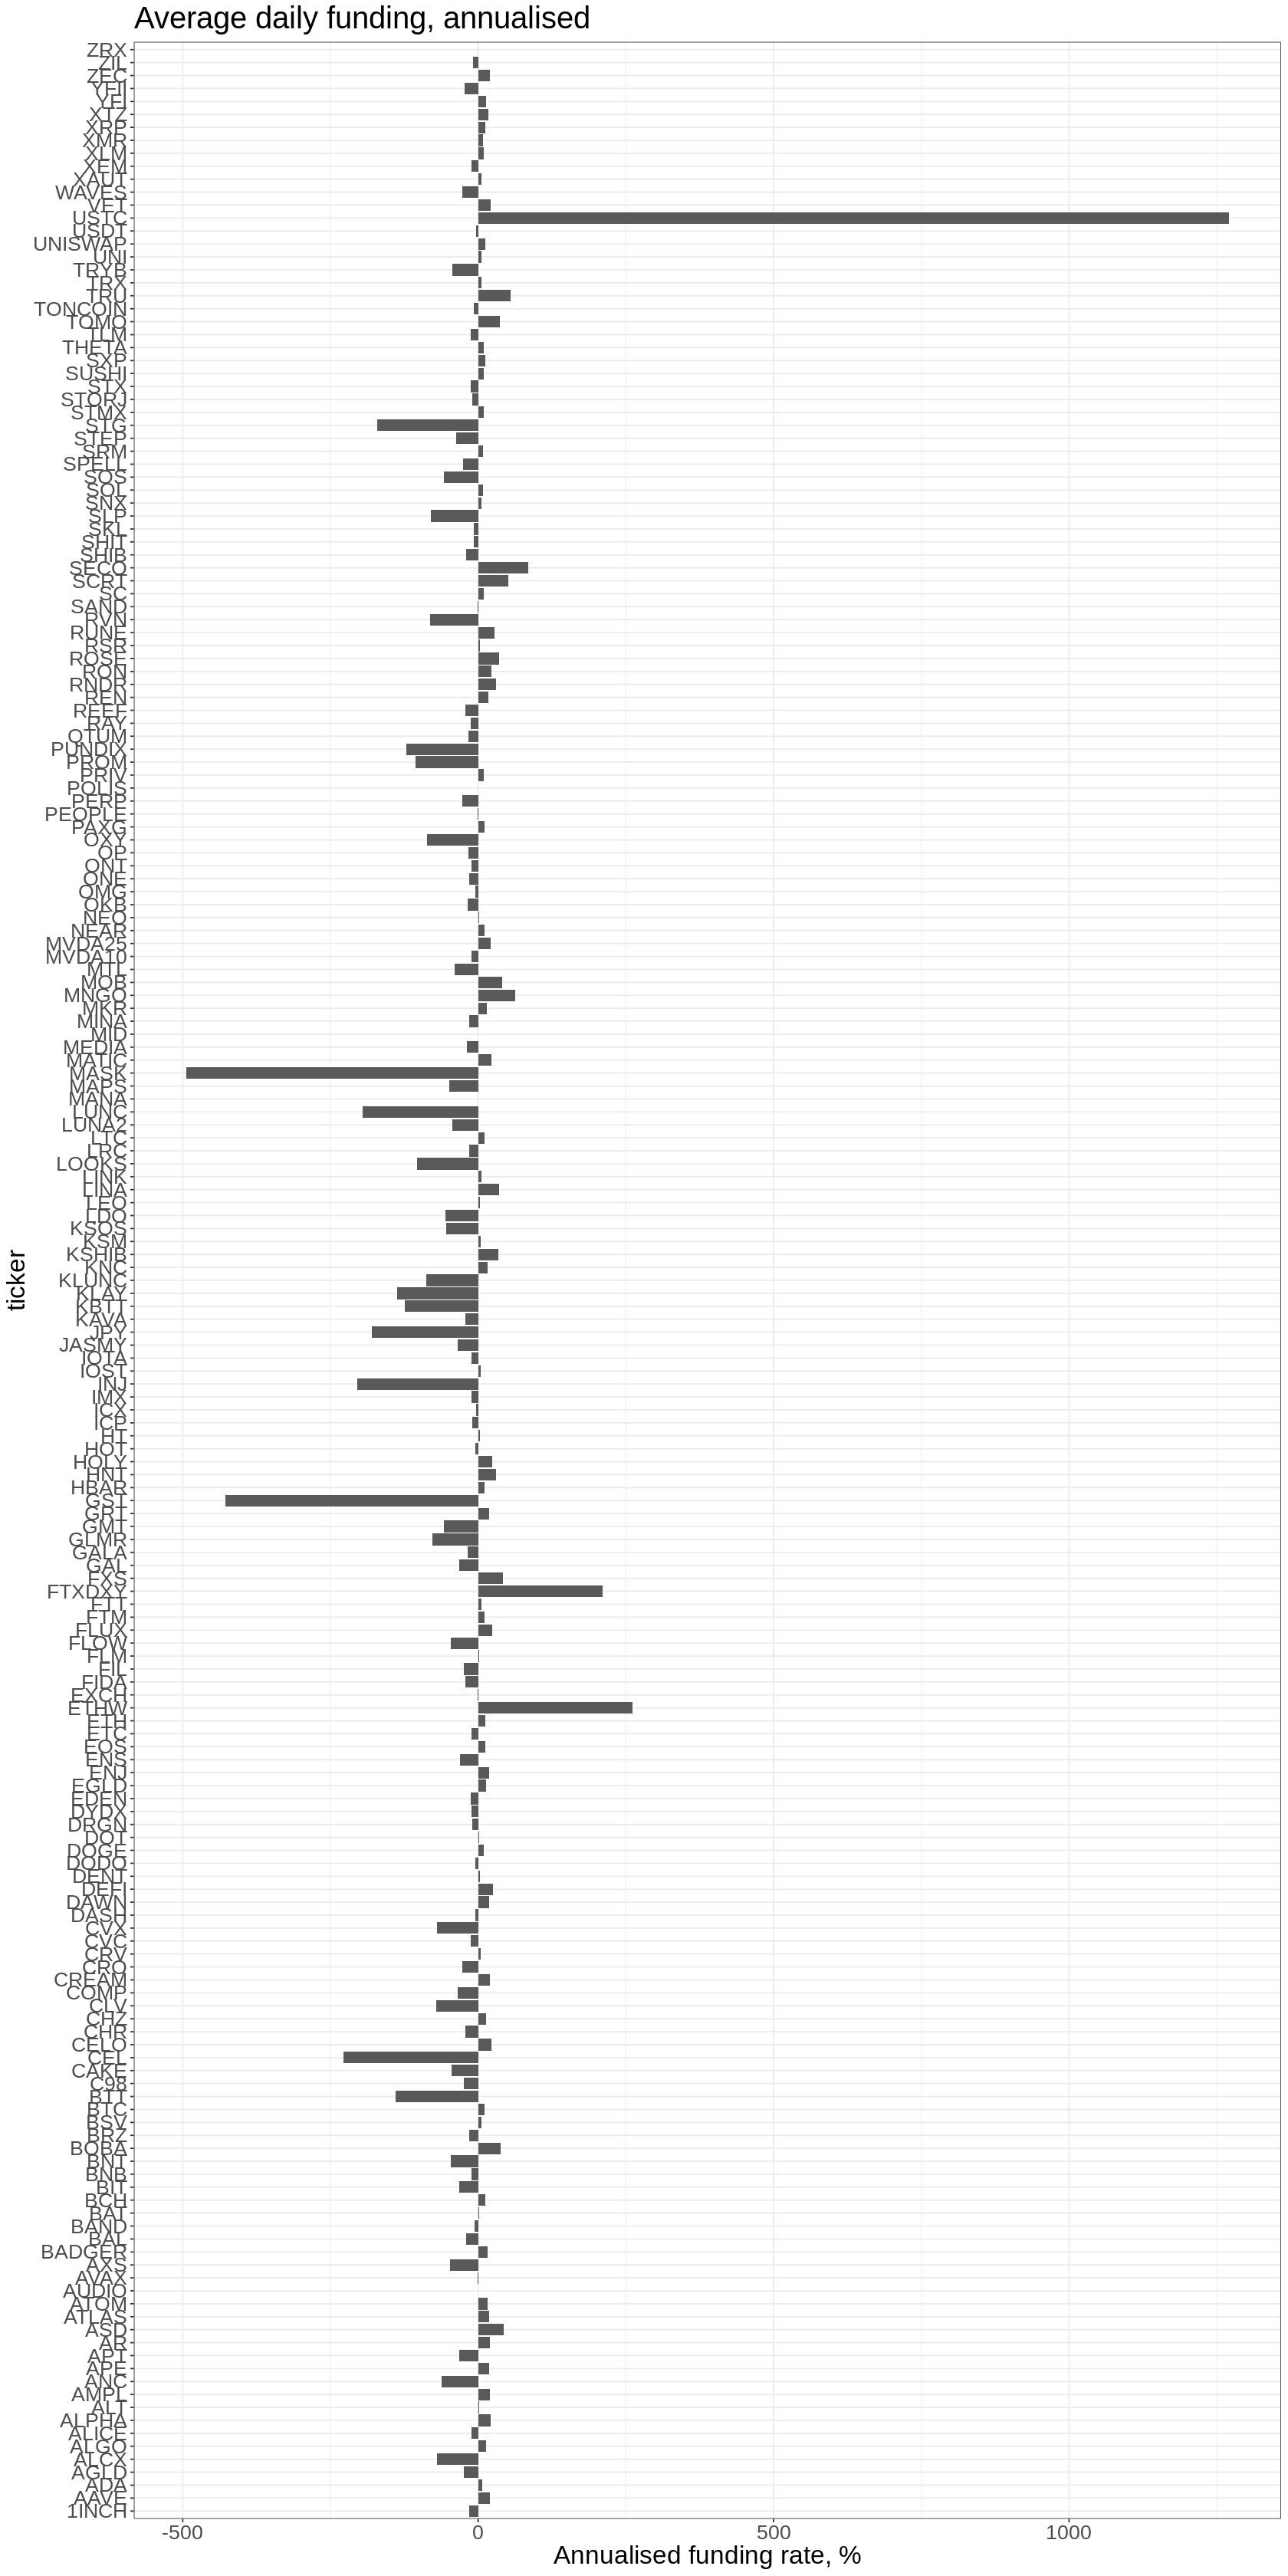

In [33]:
options(repr.plot.width = 14, repr.plot.height=28)
avg_daily_funding %>%
  mutate(ticker = str_remove(ticker, "-PERP")) %>%
  ggplot(aes(x = ticker, y = avg_funding*100*365)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(
    title = "Average daily funding, annualised",
    y = "Annualised funding rate, %"
  )
options(repr.plot.width = 14, repr.plot.height=7)

To estimate a trading horizon, let's use the average daily funding rate for all coins whose historical funding has been positive on average. 

In [34]:
cost <- 4*0.07/100
horizon <- cost/all_positive_avg
horizon

[1] 2.954801

This suggests a hold period of around 4-5 days in order for the trade to be positive EV given assumed costs. 

Based on experience, I'd like to give this a little more wiggle room, so let's assume a 7-day hold for our trading horizon.

Let's see how our model of mean 4-day funding predicts 7-day funding, on average:

In [35]:
# create funding model 
funding_model <- daily_funding %>%
  group_by(ticker) %>%
  mutate(
    # predicted funding is 7x mean funding over last 4 days
    predicted_funding = 7*(rate + dplyr::lag(rate, 1) + dplyr::lag(rate, 2) + dplyr::lag(rate, 3))/4,
    # actual funding is the sum of funding over the forward 7 days
    actual_funding = dplyr::lead(rate, 1) + dplyr::lead(rate, 2) + dplyr::lead(rate, 3) + dplyr::lead(rate, 4) + dplyr::lead(rate, 5) + dplyr::lead(rate, 6) + dplyr::lead(rate, 7)
  ) 

Here's a plot of predicted funding vs actual funding:

`geom_smooth()` using formula = 'y ~ x'


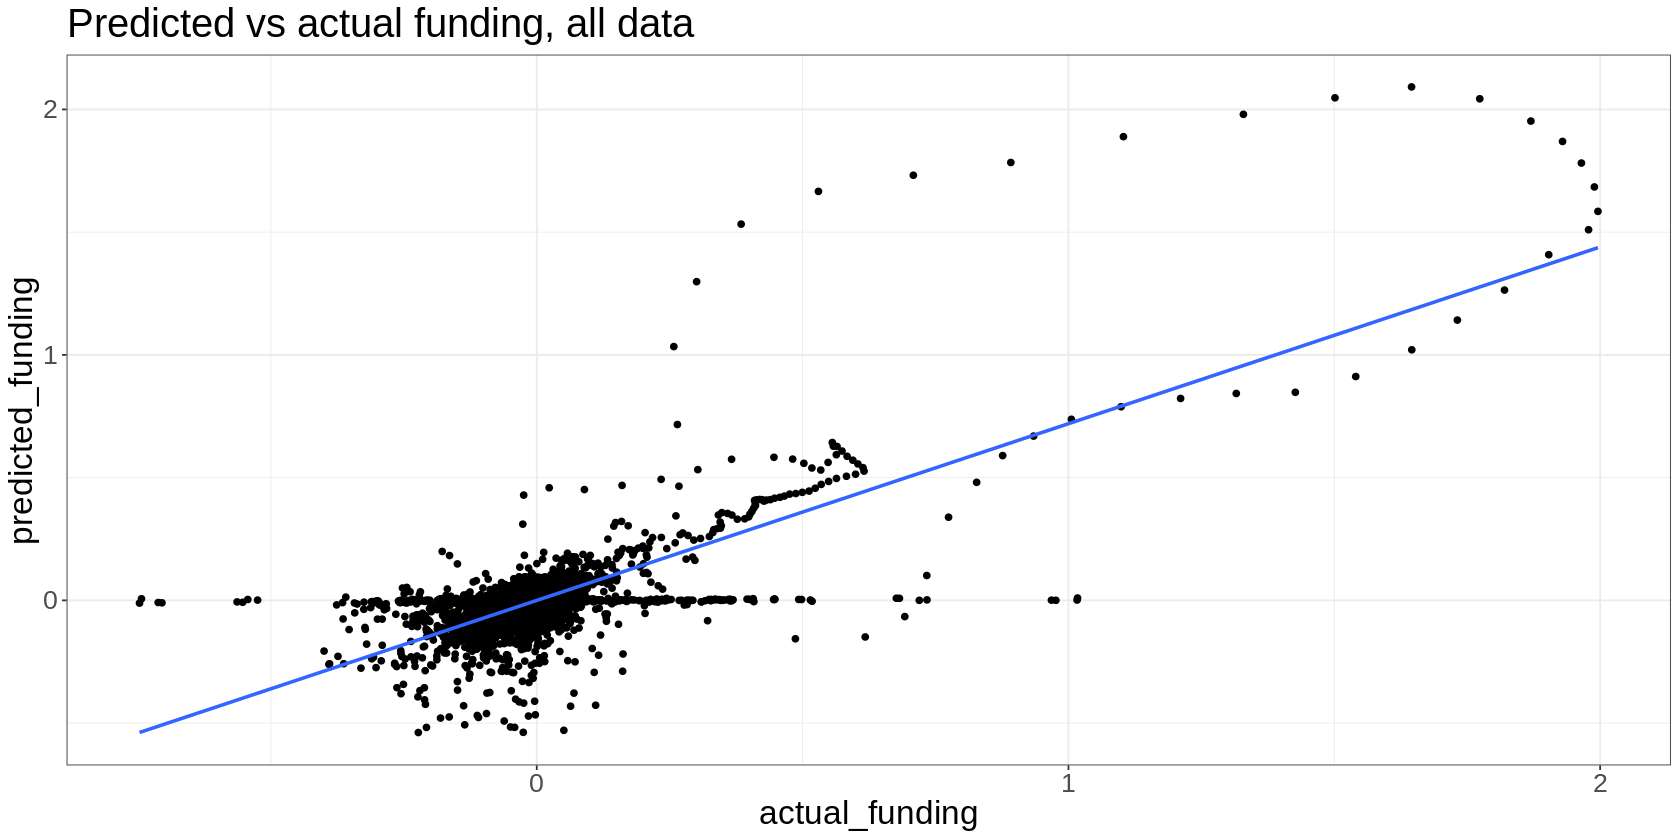

In [36]:
funding_model %>%
  na.omit() %>%
  ggplot(aes(x = actual_funding, y = predicted_funding)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(title = "Predicted vs actual funding, all data")

And with overlapping data removed:

`geom_smooth()` using formula = 'y ~ x'


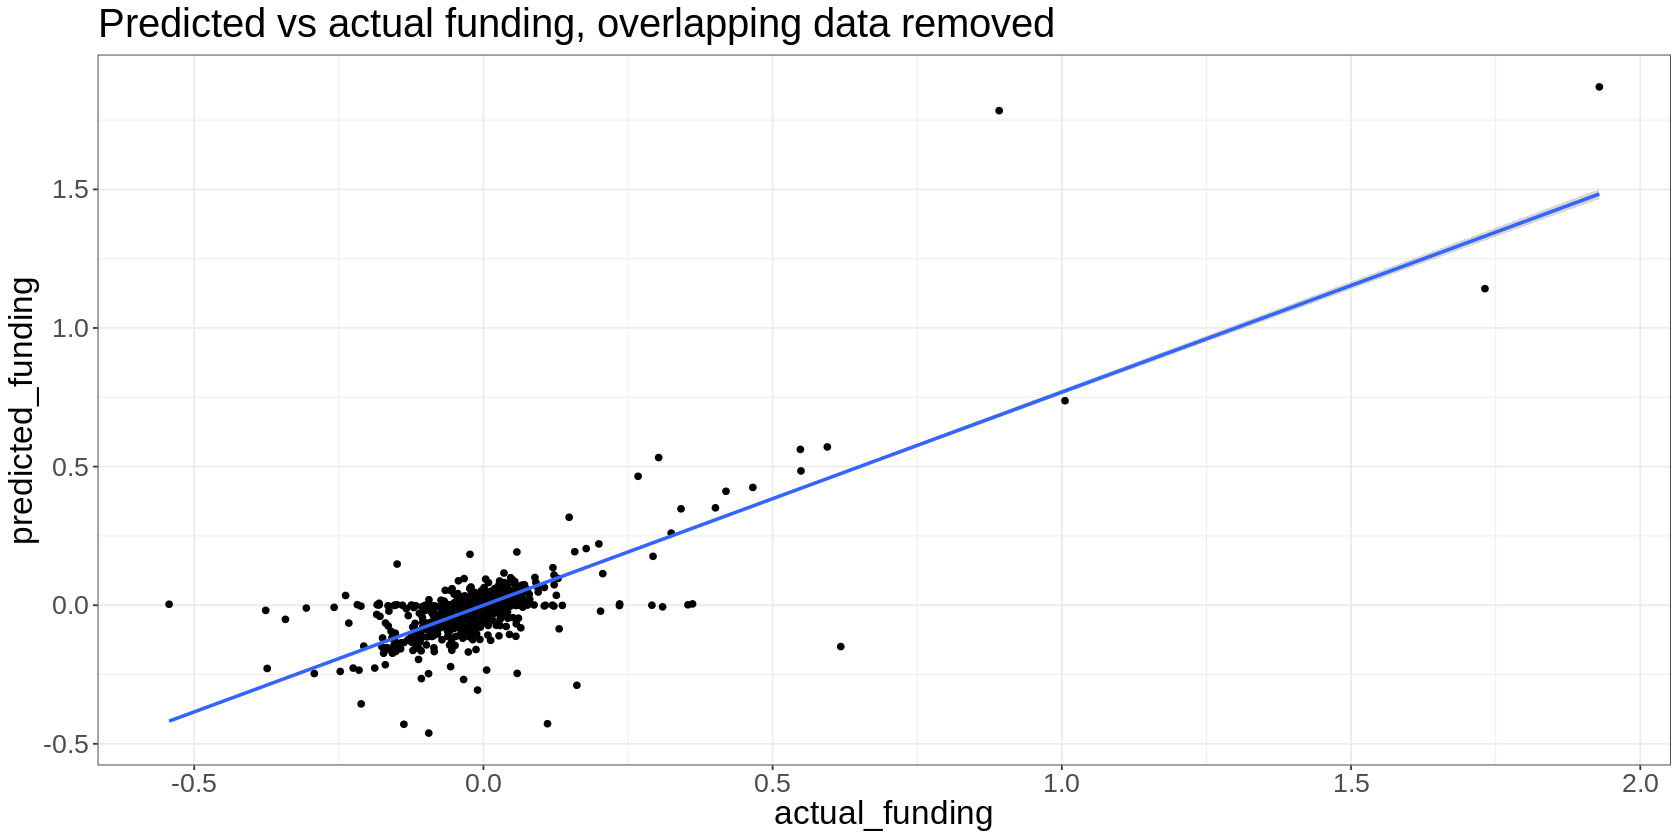

In [37]:
funding_model %>%
  group_by(ticker) %>%
  filter(row_number() %% 7 == 0) %>%
  na.omit() %>%
  ggplot(aes(x = actual_funding, y = predicted_funding)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(title = "Predicted vs actual funding, overlapping data removed")

Our simple model is, on average, a reasonable predictor of 7-day funding. 

Plotting the residuals or model error can help determine whether the model is leaving anything on the table. If our model is missing anything, we should see a non-random pattern when we plot the residuals:

`geom_smooth()` using formula = 'y ~ x'


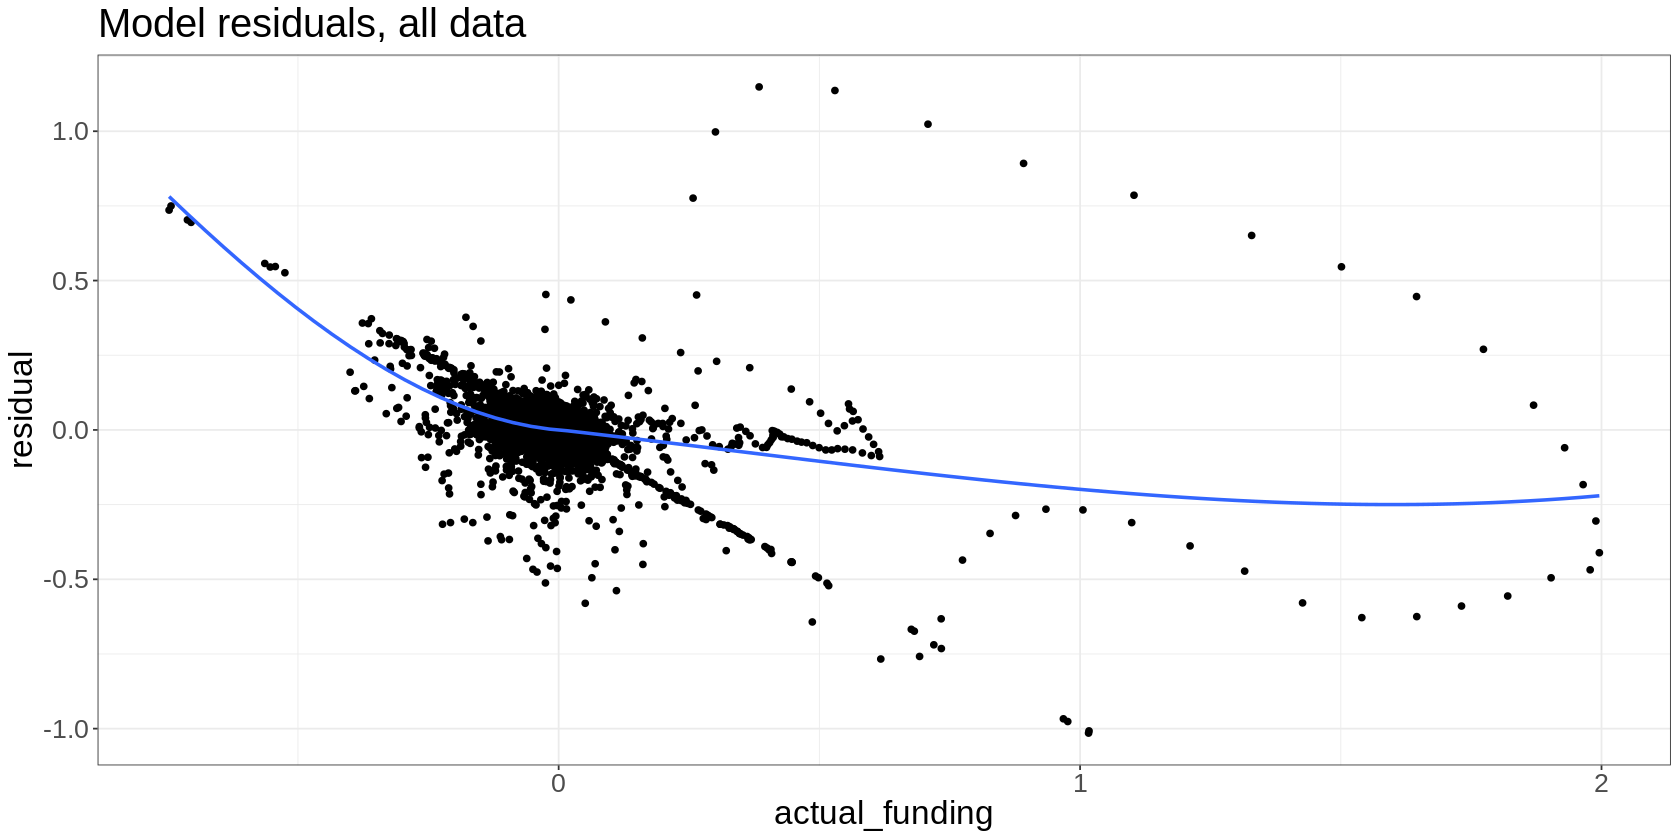

In [38]:
funding_model %>%
  mutate(residual = predicted_funding - actual_funding) %>%
  na.omit() %>%
  ggplot(aes(x = actual_funding, y = residual)) +
    geom_point() +
    geom_smooth(method = "loess", se = F) +
    labs(title = "Model residuals, all data")

And with overlapping data removed:

`geom_smooth()` using formula = 'y ~ x'


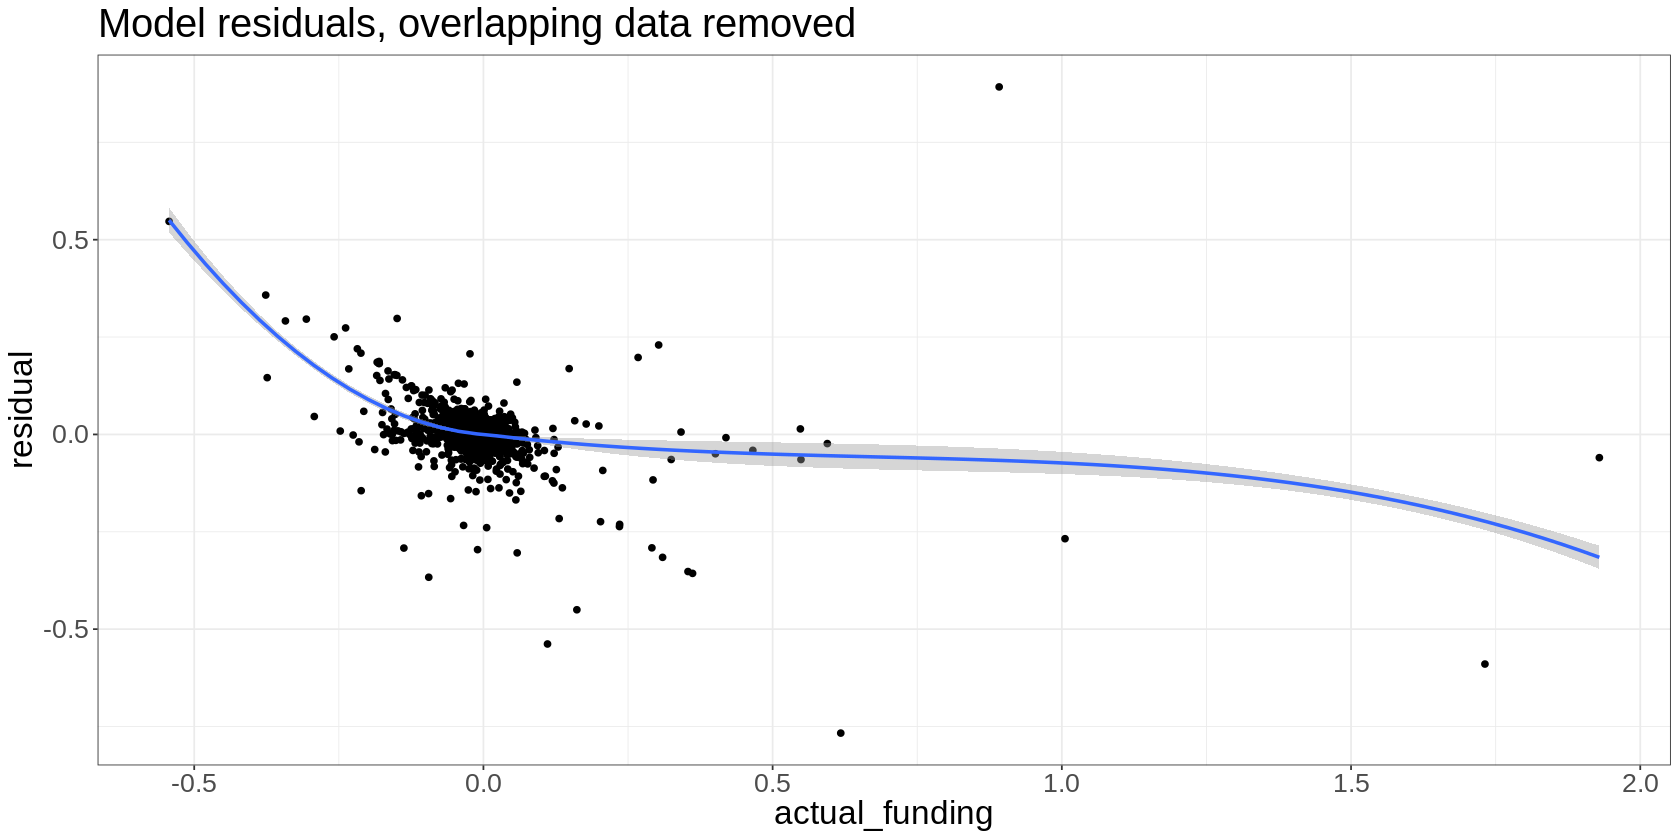

In [39]:
funding_model %>%
  group_by(ticker) %>%  
  filter(row_number() %% 7 == 0) %>%
  mutate(residual = predicted_funding - actual_funding) %>%
  na.omit() %>%
  ggplot(aes(x = actual_funding, y = residual)) +
    geom_point() +
    geom_smooth(method = "loess") +
    labs(title = "Model residuals, overlapping data removed")

We do see a non-random pattern in the residuals, suggesting the model is indeed missing something. 

In particular, it tends to over-predict large negative values. This suggests that the model doesn't do a great job of predicting large negative funding rates. We could speculate that this might be because these large negative rates tend to occur suddenly out of nowhere?

For our purposes however, I think our model is good enough. 

Let's simulate a simple trading strategy based on the model:
- rotate between the n perpetuals with the highest forecast basis, over a minimum hurdle, x, with reasonable volume. 

First, get some perpetual price data:

In [40]:
rwRtools:::transfer_lab_object(
      pod = "Crypto",
      object = "ftx_futures_ohlc_1h.feather",
      path = "."
)

futs <- feather::read_feather('ftx_futures_ohlc_1h.feather')
futs <- futs %>% mutate(date = lubridate::as_datetime(date)) %>%
  filter(str_detect(ticker, "-PERP"))

tail(futs)

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ./ftx_futures_ohlc_1h.feather  ( 232.4 M…





File successfully transferred


[1] TRUE

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX-PERP,2022-11-11 19:00:00,0.180225,0.181225,0.178750,0.181225,1227.9917
ZRX-PERP,2022-11-11 20:00:00,0.181225,0.181225,0.177650,0.177650,1274.5441
ZRX-PERP,2022-11-11 21:00:00,0.177650,0.180725,0.177650,0.180650,966.6679
ZRX-PERP,2022-11-11 22:00:00,0.180650,0.181950,0.180475,0.181950,263.9651
ZRX-PERP,2022-11-11 23:00:00,0.181950,0.181950,0.180775,0.181925,884.3130
ZRX-PERP,2022-11-12 00:00:00,0.181925,0.182625,0.181550,0.181700,106.2685


In [41]:
# make daily OHLCV (UTC midnight - UTC midnight)
daily_futs <- futs %>%
  separate(date, into = c("date", "time"), sep = " ") %>%
  group_by(ticker, date) %>%
  summarise(
    open = first(open),
    high = max(high),
    low = min(low),
    close = last(close),
    volume = sum(volume)
  ) %>%
  mutate(date = as_date(date))

tail(daily_futs)

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,open,high,low,close,volume
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX-PERP,2022-11-07,0.256250,0.263350,0.25110,0.258050,7.735182e+05
ZRX-PERP,2022-11-08,0.258050,0.261650,0.19185,0.210100,1.739116e+07
ZRX-PERP,2022-11-09,0.210100,0.213425,0.15965,0.163425,2.691925e+06
ZRX-PERP,2022-11-10,0.163425,0.196250,0.15965,0.188800,6.549381e+05
ZRX-PERP,2022-11-11,0.188800,0.196450,0.17155,0.181925,1.322139e+05
ZRX-PERP,2022-11-12,0.181925,0.182625,0.18155,0.181700,1.062685e+02


Check looks sensible

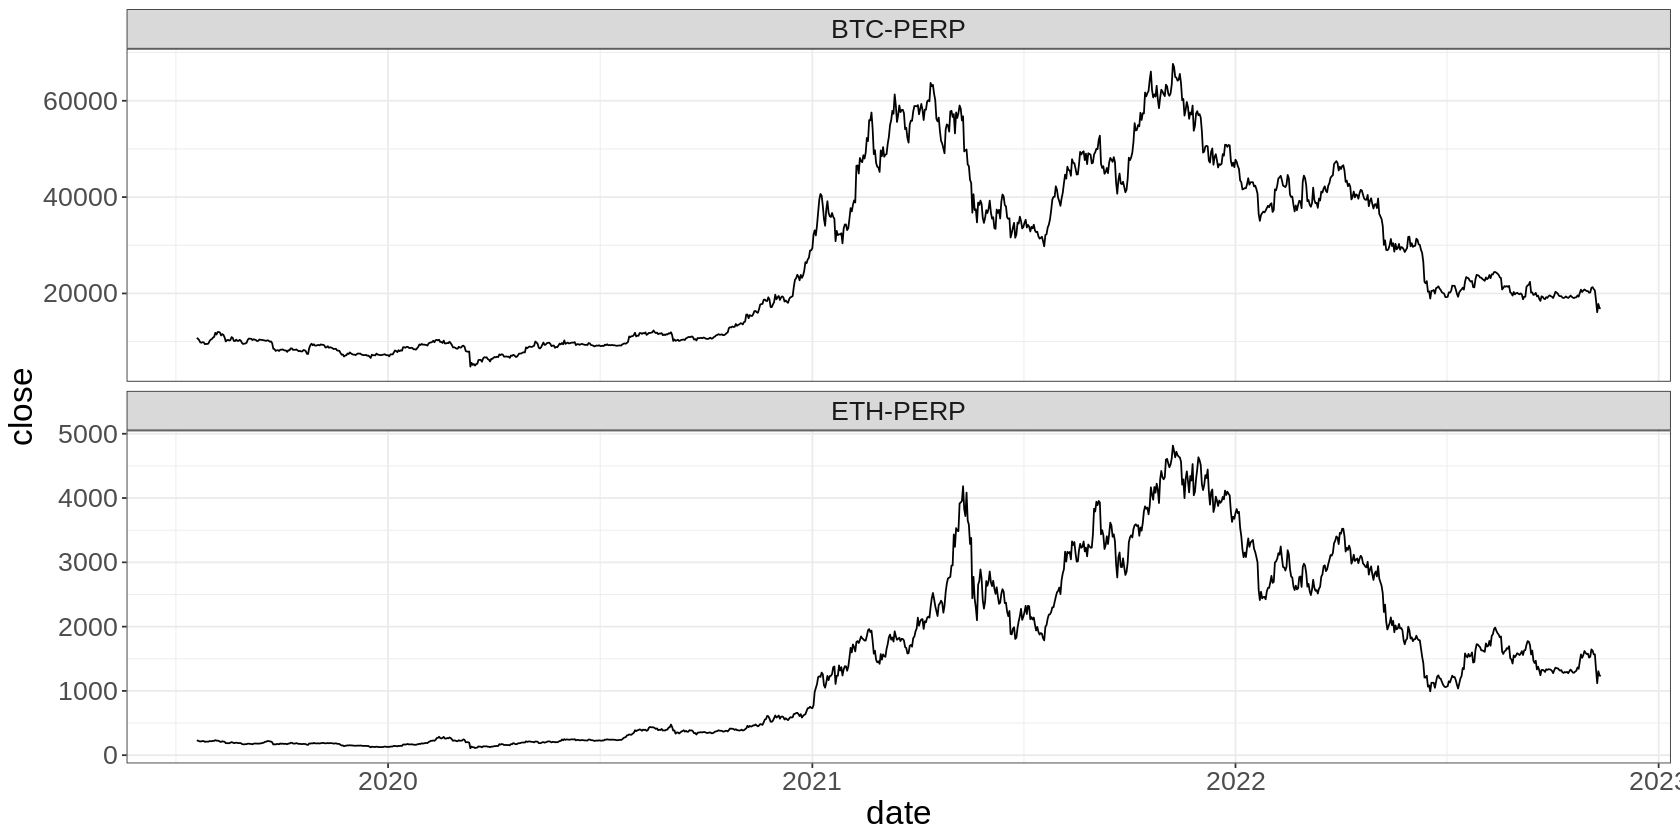

In [42]:
daily_futs %>%
  filter(ticker %in% c("BTC-PERP", "ETH-PERP")) %>%
  ggplot(aes(x = date, y = close)) +
    geom_line() +
    facet_wrap(~ticker, ncol = 1, scales = "free_y") 

Get spot data

In [43]:
rwRtools:::transfer_lab_object(
      pod = "Crypto",
      object = "ftx_spot_ohlc_1h.feather",
      path = "."
)

spot <- feather::read_feather('ftx_spot_ohlc_1h.feather')
spot <- spot %>% mutate(date = lubridate::as_datetime(date)) 
tail(spot) 

ℹ Downloading ftx_spot_ohlc_1h.feather

✔ Saved ftx_spot_ohlc_1h.feather to ./ftx_spot_ohlc_1h.feather  ( 753.2 Mb )





File successfully transferred


[1] TRUE

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX/USD,2022-11-11 20:00:00,0.167000,0.167075,0.165825,0.166125,54.71178
ZRX/USD,2022-11-11 21:00:00,0.166125,0.175300,0.166125,0.166175,257.98725
ZRX/USD,2022-11-11 22:00:00,0.166175,0.173775,0.166175,0.173650,84.28035
ZRX/USD,2022-11-11 23:00:00,0.173650,0.174525,0.149425,0.154225,1511.33040
ZRX/USD,2022-11-12 00:00:00,0.154225,0.162675,0.154175,0.154175,103.75790
ZRX/USD,2022-11-12 01:00:00,0.154175,0.169950,0.154175,0.169950,340.88367


In [44]:
# wrangle into daily 
daily_spot <- spot %>%
  separate(date, into = c("date", "time"), sep = " ") %>%
  group_by(ticker, date) %>%
  summarise(
    open = first(open),
    high = max(high),
    low = min(low),
    close = last(close),
    volume = sum(volume)
  ) %>%
  mutate(date = as_date(date))
  
tail(daily_spot)

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,open,high,low,close,volume
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX/USD,2022-11-07,0.256775,0.26305,0.251800,0.258325,12330.9352
ZRX/USD,2022-11-08,0.258500,0.26125,0.191775,0.209500,245721.3214
ZRX/USD,2022-11-09,0.209500,0.21235,0.159975,0.163025,49777.9139
ZRX/USD,2022-11-10,0.163025,0.20500,0.142950,0.185850,21379.0029
ZRX/USD,2022-11-11,0.185850,0.19505,0.149425,0.154225,6842.0719
ZRX/USD,2022-11-12,0.154225,0.16995,0.154175,0.169950,444.6416


Check data looks sensible

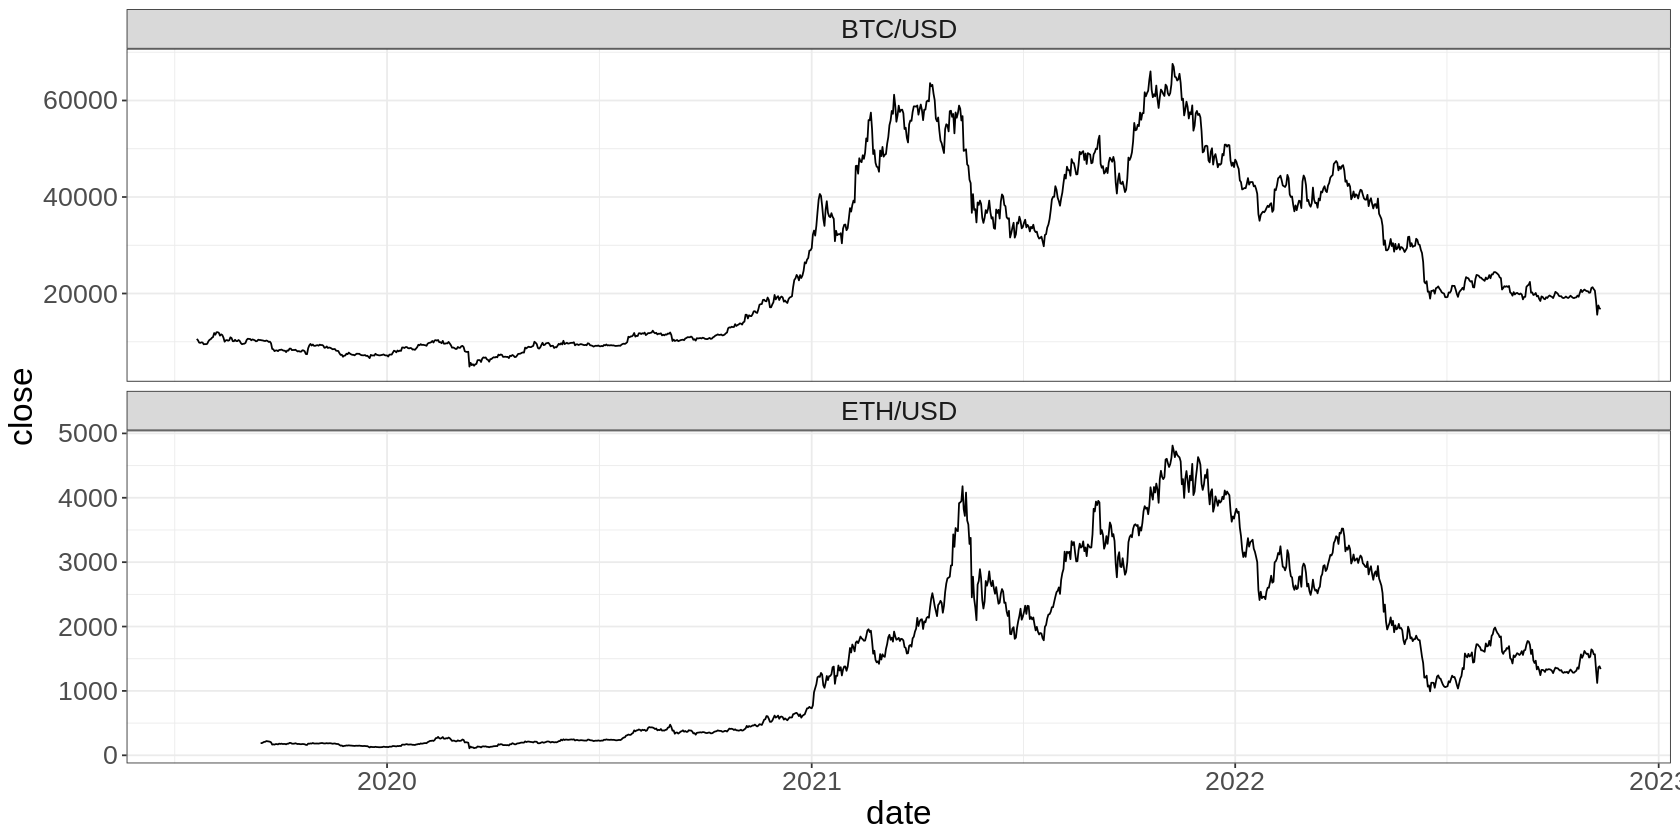

In [45]:
daily_spot %>%
  filter(ticker %in% c("BTC/USD", "ETH/USD")) %>%
  ggplot(aes(x = date, y = close)) +
    geom_line() +
    facet_wrap(~ticker, ncol = 1, scales = "free_y") 

Make universe data set from stuff where:
- We have perp and spot daily closes
- average 5-day volume in the perp is above some cutoff

Also ditch AMPL as it does some funky rebase stuff that we can't really account for in our model. 

In [48]:
cutoff = 1.0e6  # minium 5-day average volume

universe_df <- daily_futs %>%
  select(ticker, date, close, volume) %>%
  rename("close_perp" = close, "volume_perp" = volume) %>%
  # join spot
    # first drop "-PERP" from ticker
  mutate(ticker = str_remove(ticker, "-PERP")) %>%
  left_join(
    daily_spot %>% 
      # likewise drop "/USD" from ticker
      mutate(ticker = str_remove(ticker, "/USD")) %>%
      select(ticker, date, close) %>%
      rename("close_spot" = close),
    by = c("date", "ticker")
  ) %>%
  # ditch rows where we don't have both perp and spot closing prices
  na.omit() %>%
  # ditch AMPL
  filter(ticker != "AMPL") %>%
  arrange(date) %>%
  # get 5-day rolling mean volume
  group_by(ticker) %>%
  mutate(roll_mean_volume = slider::slide_dbl(.x = volume_perp, .f = mean, .before = 5)) %>%
  # flag if something is in universe
  mutate(is_universe = case_when(dplyr::lag(roll_mean_volume) > cutoff ~ 1, TRUE ~ 0))

tail(universe_df)

ticker,date,close_perp,volume_perp,close_spot,roll_mean_volume,is_universe
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WAVES,2022-11-12,2.25050,536.9005,2.14750,5445016,1
XAUT,2022-11-12,1772.60000,0.0000,1756.50000,386252,0
XRP,2022-11-12,0.37745,353369.5470,0.37050,109603744,1
YFI,2022-11-12,6195.00000,236.0200,5565.00000,8397159,1
YFII,2022-11-12,1745.00000,275.5510,1560.00000,5348169,1
ZRX,2022-11-12,0.18170,106.2685,0.16995,3607310,1


Check how many perpetuals are in our universe given these criteria:

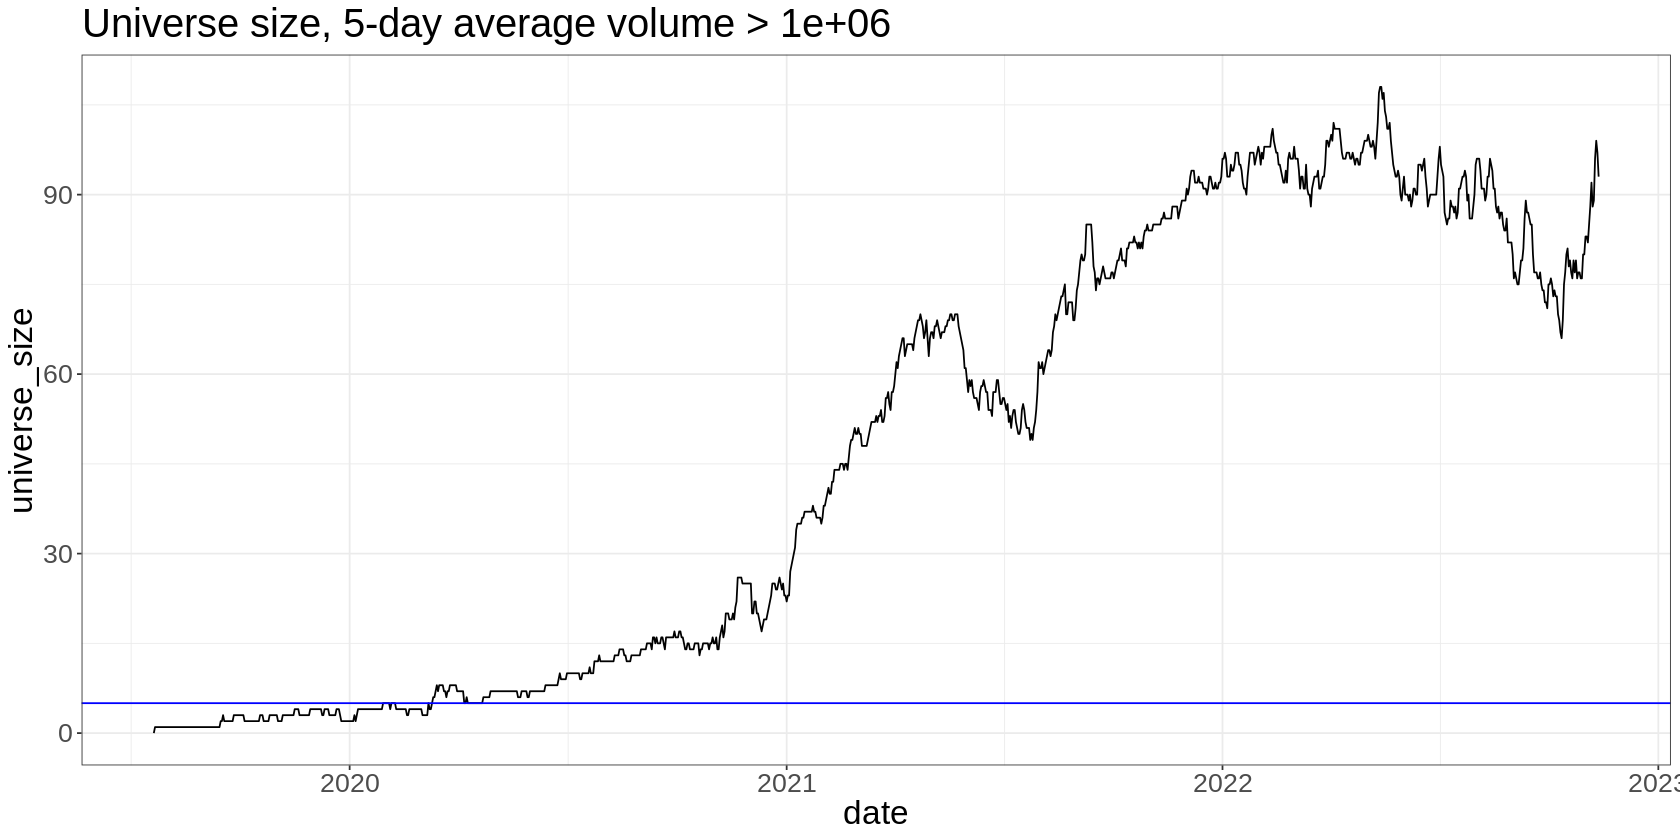

In [49]:
# how many in our universe?
universe_cutoff <- 5

universe_df %>%
  group_by(date) %>%
  summarise(universe_size = sum(is_universe)) %>%
  ggplot(aes(x = date, y = universe_size)) +
    geom_line() +
    geom_hline(yintercept = universe_cutoff, colour = "blue") +
    labs(title = glue("Universe size, 5-day average volume > {cutoff}"))

We have 5 or more coins in our universe from early 2020 onwards. We'll filter our data set prior to that date:

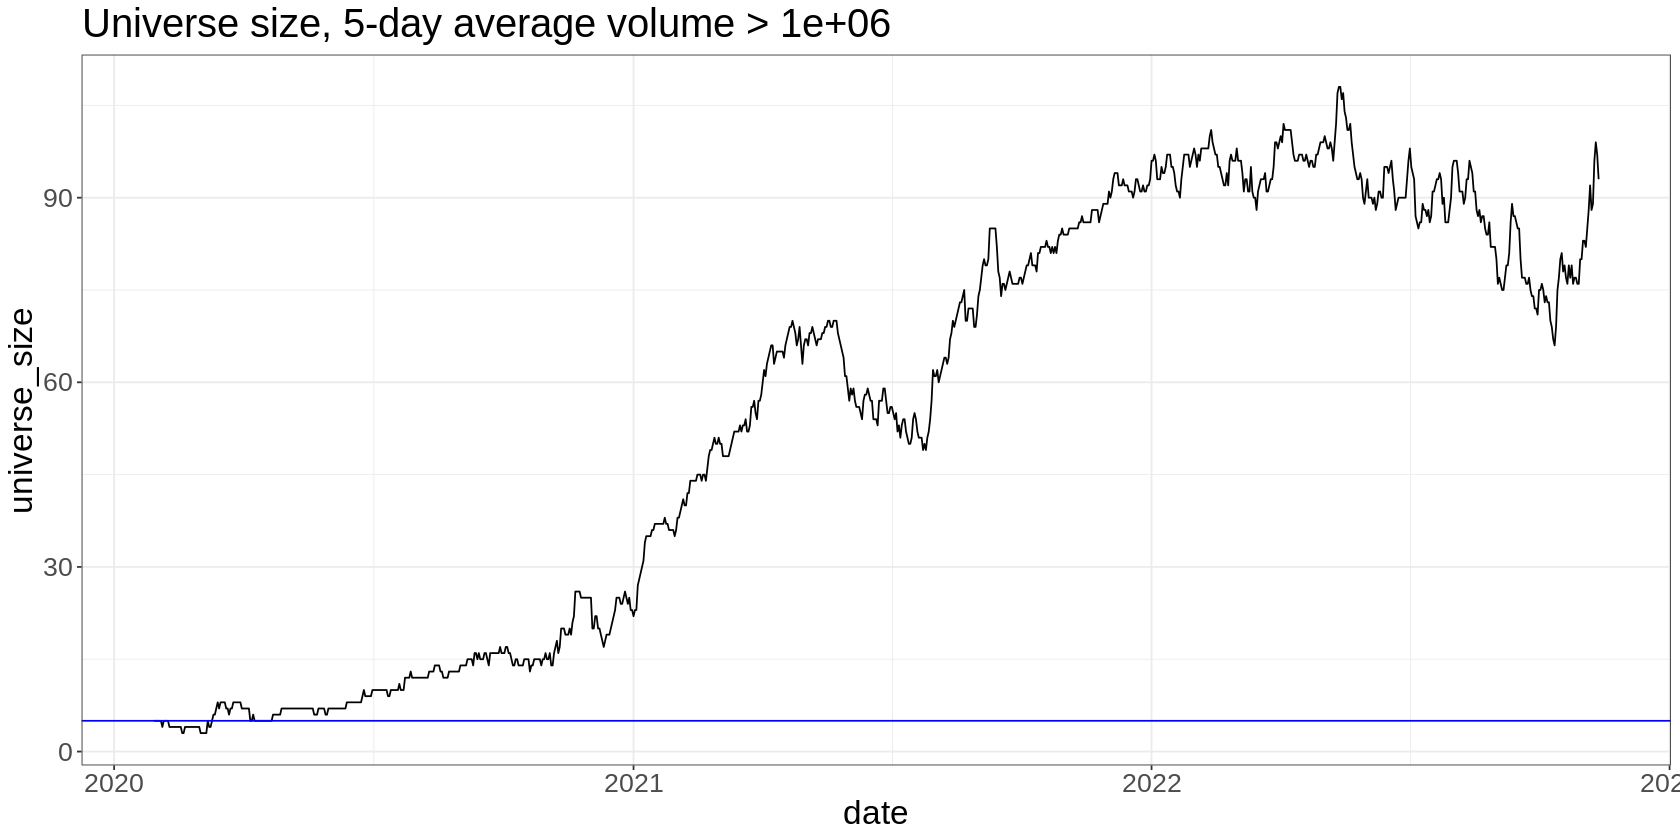

In [50]:
cutoff_date <- universe_df %>%
  group_by(date) %>%
  summarise(universe_size = sum(is_universe)) %>%
  filter(universe_size >= universe_cutoff) %>%
  summarise(cutoff_date = first(date)) %>%
  pull(cutoff_date)

universe_df <- universe_df %>%
  filter(date >= cutoff_date)

universe_df %>%
  group_by(date) %>%
  summarise(universe_size = sum(is_universe)) %>%
  ggplot(aes(x = date, y = universe_size)) +
    geom_line() +
    geom_hline(yintercept = universe_cutoff, colour = "blue") +
    labs(title = glue("Universe size, 5-day average volume > {cutoff}"))

Next we'll create a backtest df by joining the daily funding rate to our universe df and calculating positions from our funding model. 

The timestamp in the funding df represents when funding is paid. eg if the timesteamp is 2:00:00, it represents the funding accrued for the period 1:00:00-1:59:59 and paid on 2:00:00.

So to align funding rate with the hour in which it is accrued, we nead to *lead* the hourly funding rate. This is what we should use in our model of future funding.

Remake daily funding df accordingly. In this df, `rate` is the funding accrued on that day. (In reality it's accrued throughout the day - but we'll essentially summarise the dynamics to a daily resolution).

In [51]:
daily_funding <- funding %>% 
  mutate(hour = hour(date), date = date(date)) %>% 
  # group by ticker and lead hourly funding rate
  group_by(ticker) %>%
  mutate(rate = dplyr::lead(rate)) %>%
  # group by ticker and day and sum to get daily funding
  group_by(ticker, date) %>% 
  summarise(rate = sum(rate, na.rm = TRUE))

tail(daily_funding)

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,rate
<chr>,<date>,<dbl>
ZRX-PERP,2022-11-07,-0.000183
ZRX-PERP,2022-11-08,-0.001008
ZRX-PERP,2022-11-09,-0.003670
ZRX-PERP,2022-11-10,-0.004096
ZRX-PERP,2022-11-11,-0.006597
ZRX-PERP,2022-11-12,0.000000


Model of predicted funding:

In [52]:
daily_funding <- daily_funding %>%
  group_by(ticker) %>%
  mutate(
    # predicted funding is 7x mean funding over last 4 days
    predicted_funding = 7*(rate + dplyr::lag(rate, 1) + dplyr::lag(rate, 2) + dplyr::lag(rate, 3))/4
  ) 

tail(daily_funding)

ticker,date,rate,predicted_funding
<chr>,<date>,<dbl>,<dbl>
ZRX-PERP,2022-11-07,-0.000183,0.00035350
ZRX-PERP,2022-11-08,-0.001008,-0.00183925
ZRX-PERP,2022-11-09,-0.003670,-0.00849975
ZRX-PERP,2022-11-10,-0.004096,-0.01567475
ZRX-PERP,2022-11-11,-0.006597,-0.02689925
ZRX-PERP,2022-11-12,0.000000,-0.02513525


Create a backtest df containing everything we need to do a rough simulation of our basis strategy:
- daily perpetual futures returns
- daily spot returns
- daily accrued perpetual funding rates
- model predicted funding rate
- is_universe flag

In [53]:
backtest_df <- universe_df %>%
  left_join(daily_funding %>% mutate(ticker = str_remove(ticker, "-PERP")), by = c("date", "ticker")) %>%
  # calculate spot return, perp return, and funding return
  arrange(date) %>%
  group_by(ticker) %>%
  mutate(
    return_perp = (close_perp - dplyr::lag(close_perp))/dplyr::lag(close_perp),
    return_spot = (close_spot - dplyr::lag(close_spot))/dplyr::lag(close_spot),
    fwd_return_perp = dplyr::lead(return_perp),
    fwd_return_spot = dplyr::lead(return_spot),
    fwd_funding = dplyr::lead(rate, 2)
  ) %>%
  na.omit()

head(backtest_df)

ticker,date,close_perp,volume_perp,close_spot,roll_mean_volume,is_universe,rate,predicted_funding,return_perp,return_spot,fwd_return_perp,fwd_return_spot,fwd_funding
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASD,2020-01-30,0.06549,189333.3,0.06533,238540.5,0,0.002477,0.02561300,0.020093458,0.0128682171,-0.005649718,0.001224552,0.009560
BNB,2020-01-30,18.55000,2034073.3,18.57000,1369262.6,1,0.000562,0.00058275,0.038488453,0.0400448054,-0.019946092,-0.020678514,-0.000791
BTC,2020-01-30,9515.50000,325949339.9,9507.50000,277170331.5,1,0.001394,0.00662200,0.023639835,0.0241839922,-0.017129946,-0.017775440,0.001396
ETH,2020-01-30,184.89000,27151825.2,184.51000,19520451.9,1,0.001945,0.01186150,0.064605286,0.0641942554,-0.027421710,-0.026123245,0.001261
PAXG,2020-01-30,1576.70000,5005311.5,1575.90000,2397948.5,1,-0.000181,-0.00304325,-0.001330124,-0.0004439934,0.008625610,0.008629989,-0.001190
TRYB,2020-01-30,0.16668,1216256.4,0.16742,477547.0,0,-0.002602,-0.01471050,-0.004003585,-0.0028588446,0.001619870,-0.001493251,0.042525


Next we take positions in the top five by predicted funding, over some threshold. 

In this simulation, we'll sometimes have less than ten positions since we won't always have ten perps with a high enough funding rate - especially early in the simulation. 

Regardless of the number of positions, we'll assume an equal dollar weight across them all. 

In [54]:
threshold_ann <- 0.75  # annualised funding threshold
threshold <- 7*threshold_ann/(365)  # next 7-day's funding threshold
threshold

top_n <- universe_cutoff

positions_df <- backtest_df %>%
  filter(is_universe == TRUE) %>%
  # get rid of anything whose predicted funding rate falls under the threshold
  filter(predicted_funding > threshold) %>%
  group_by(date) %>%
  # rank by predicted funding rate
  mutate(rank = row_number(desc(predicted_funding))) %>%
  mutate(pos = case_when(rank <= universe_cutoff ~ 1, TRUE ~ 0)) %>%
  select(ticker, date, pos)

tail(positions_df)

[1] 0.01438356

ticker,date,pos
<chr>,<date>,<dbl>
SRM,2022-11-10,0
STORJ,2022-11-10,0
SUSHI,2022-11-10,0
TOMO,2022-11-10,0
TRU,2022-11-10,1
TRX,2022-11-10,0


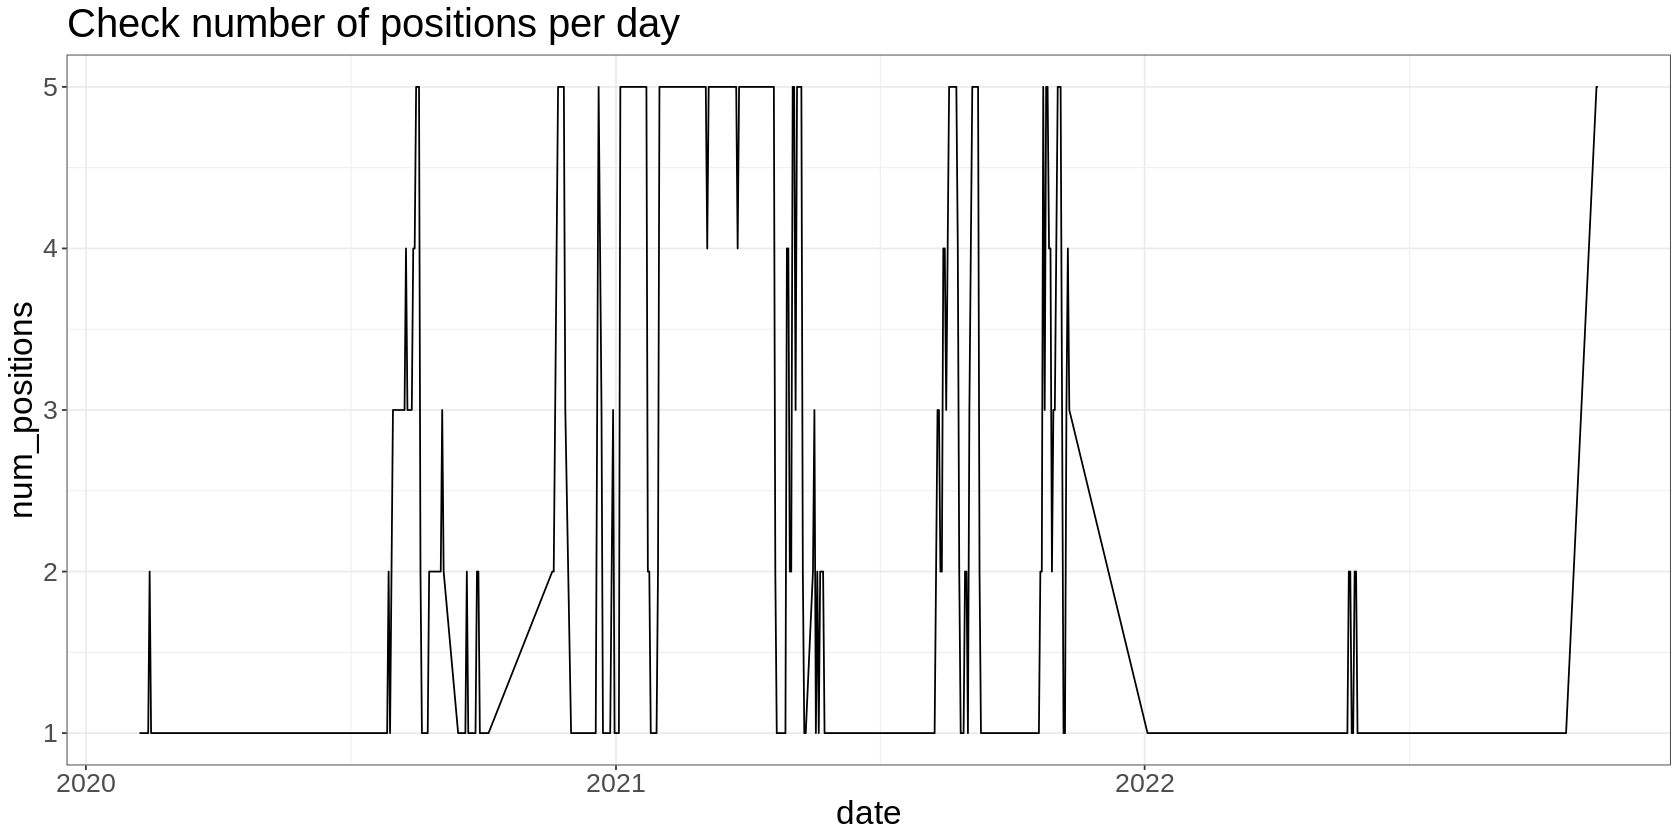

In [55]:
positions_df %>%
  group_by(date) %>%
  summarise(num_positions = sum(pos)) %>%
  ggplot(aes(x = date, y = num_positions)) +
    geom_line() +
    labs(title = "Check number of positions per day")

Next, we'll estimate costs in basis points.

To get costs, we need to know when we changed positions. But we filtered some data on `is_universe` when calcualting positions, so we need to join positions back onto backtest_df and replance any NA in the position column with 0:

In [56]:
cost <- 0.1/100

backtest_df <- positions_df %>%
  ungroup() %>%
  # right join onto backtest_df and set position to 0 for resulting NA
  right_join(backtest_df %>% select(ticker, date, fwd_return_perp, fwd_return_spot, fwd_funding), by = c("ticker", "date")) %>%
  replace_na(list(pos = 0)) %>%
  # calculate costs from change in position
  group_by(ticker) %>%
  mutate(
    # when did we change a position?
    diff_pos = c(0, abs(diff(pos))),
    costs = case_when(diff_pos == 1 ~ cost, TRUE ~ 0)
  )

tail(backtest_df)

ticker,date,pos,fwd_return_perp,fwd_return_spot,fwd_funding,diff_pos,costs
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WAVES,2022-11-10,0,-0.03014969,-0.13398693,0,0,0
XAUT,2022-11-10,0,-0.03866804,-0.02092905,0,0,0
XRP,2022-11-10,0,0.02038115,-0.03444105,0,0,0
YFI,2022-11-10,0,-0.09752438,-0.29670330,0,0,0
YFII,2022-11-10,0,0.20821918,0.03191138,0,0,0
ZRX,2022-11-10,0,-0.03641419,-0.17016411,0,0,0


Check we're not trading any tickers that we'd ditch, eg AMPL

In [57]:
backtest_df %>% filter(pos == 1) %>% distinct(ticker) %>% pull()

[1] "ASD"    "ETH"    "BTC"    "SXP"    "KNC"    "SOL"    "COMP"   "BAL"   
 [9] "TRX"    "LTC"    "SUSHI"  "CREAM"  "AAVE"   "MATIC"  "HT"     "SNX"   
[17] "TOMO"   "OKB"    "1INCH"  "GRT"    "YFI"    "ALPHA"  "BAND"   "YFII"  
[25] "XRP"    "TRU"    "RSR"    "BAT"    "REN"    "CRV"    "TRYB"   "BADGER"
[33] "LINA"   "PERP"   "SECO"   "HOLY"   "LEO"    "RAY"    "FIDA"   "ENJ"   
[41] "BNT"    "ZRX"    "FTM"    "CHZ"    "OXY"    "DENT"   "HNT"    "STMX"  
[49] "AUDIO"  "MTL"    "SAND"   "DAWN"   "REEF"   "DODO"   "CRO"    "MAPS"  
[57] "STORJ"  "SKL"    "PUNDIX" "PROM"   "STEP"   "CLV"    "C98"    "CHR"   
[65] "MNGO"   "AGLD"   "ALCX"   "BIT"    "ATLAS"  "SLP"    "POLIS"  "SPELL" 
[73] "MANA"   "CVX"    "KBTT"   "KSOS"   "GST"    "FXS"    "KSHIB"

What do daily costs look like?

Warning message:
“Removed 8 rows containing missing values (`geom_line()`).”


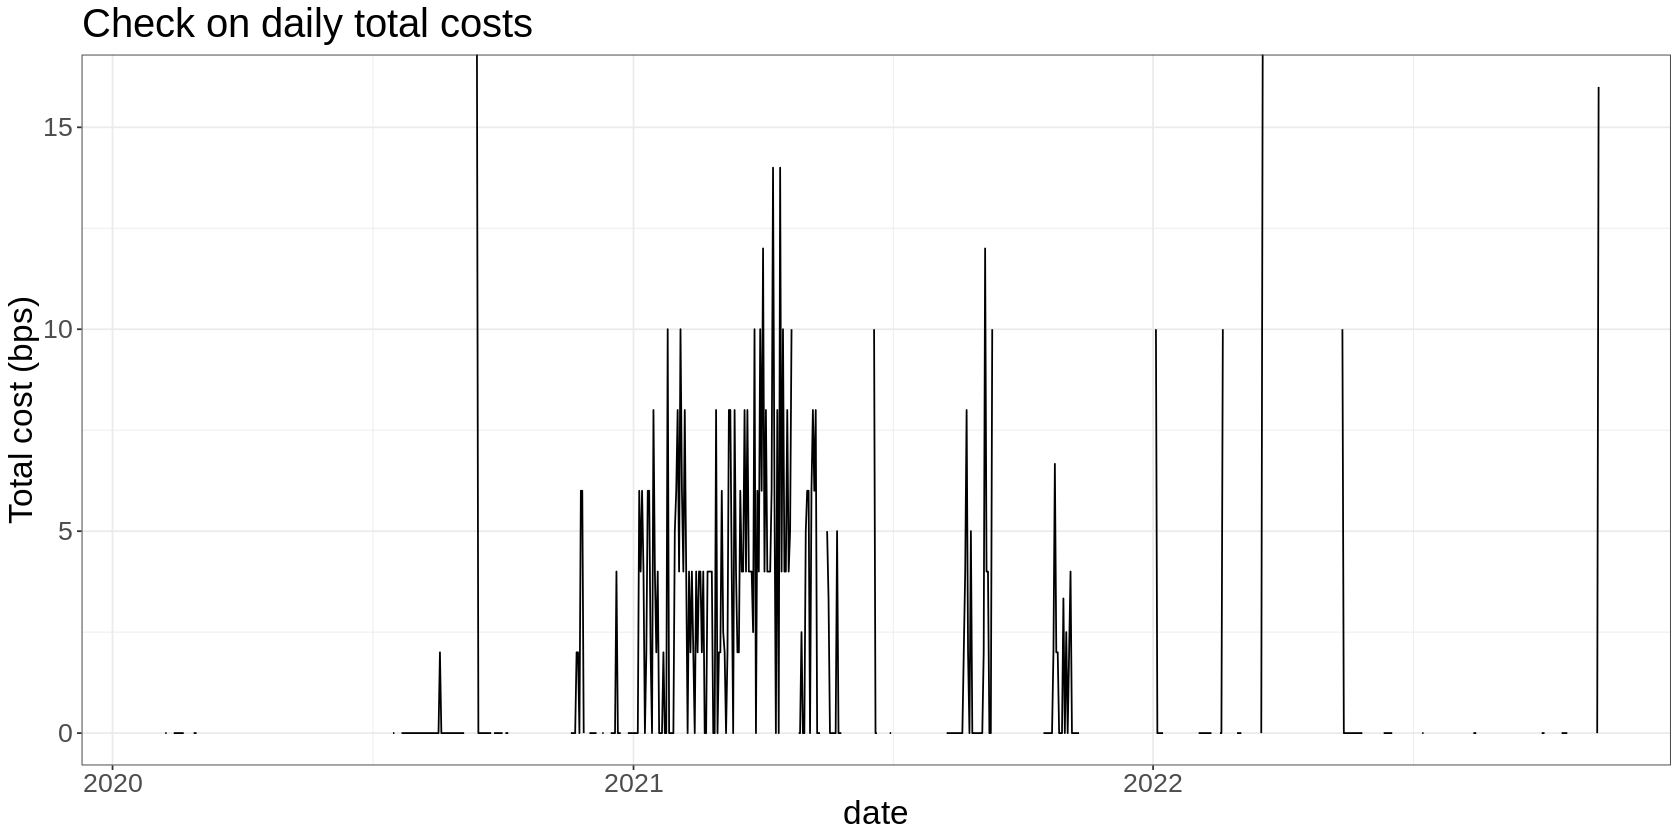

In [58]:
backtest_df %>%
  group_by(date) %>%
  summarise(
    num_positions = sum(pos),
    tot_cost = sum(costs)/num_positions) %>%
  ggplot(aes(x = date, y = tot_cost*10000)) +
    geom_line() + 
    labs(
      title = "Check on daily total costs",
      y = "Total cost (bps)"
    )

Next we'll simulate pnl to our simple perp basis funding strategy.

We could calculate the number of basis points accumulated by holding various positions, but I think it's easier to reason about if we assume that we allocate a certain constant dollar amount to the strategy and calculate pnl in dollars. 

In [59]:
capital <- 1000

results_df <- backtest_df %>%
  group_by(date) %>%
  summarise(
    num_positions = sum(pos),
    diff_pos = sum(diff_pos),
    # pnl to being equal weight in the short perp positions (half our capital is in perps)
    perp_pnl = case_when(num_positions > 0 ~ sum(-pos*fwd_return_perp*capital/(2*top_n), na.rm = TRUE), TRUE ~ 0.),
    # pnl to being equal weight in the long spot positions (half our capital is in spot)
    spot_pnl = case_when(num_positions > 0 ~ sum(pos*fwd_return_spot*capital/(2*top_n), na.rm = TRUE), TRUE ~ 0.),
    # pnl from change in basis
    basis_change_pnl = (perp_pnl + spot_pnl),
    # pnl from funding on positions (we get funding on the half of our capital which is short perps)
    funding_pnl = case_when(num_positions > 0 ~ sum(pos*fwd_funding*capital/(2*top_n)), TRUE ~ 0.),
    # costs accrue proportionally to each position change (noting no minimum commission)
    # costs = case_when(diff_pos > 0 ~ -sum(costs*capital*(diff_pos/num_positions), na.rm = TRUE), TRUE ~ 0.),
    costs = sum(-costs*diff_pos, na.rm = TRUE)*capital/top_n,
    total_pnl = basis_change_pnl + funding_pnl + costs
  )

tail(results_df, 10)

date,num_positions,diff_pos,perp_pnl,spot_pnl,basis_change_pnl,funding_pnl,costs,total_pnl
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-11-01,0,0,0.00000,0.00000,0.000000,0.0000,0.0,0.00000
2022-11-02,0,0,0.00000,0.00000,0.000000,0.0000,0.0,0.00000
2022-11-03,0,0,0.00000,0.00000,0.000000,0.0000,0.0,0.00000
2022-11-04,0,0,0.00000,0.00000,0.000000,0.0000,0.0,0.00000
2022-11-05,0,0,0.00000,0.00000,0.000000,0.0000,0.0,0.00000
2022-11-06,0,0,0.00000,0.00000,0.000000,0.0000,0.0,0.00000
2022-11-07,0,0,0.00000,0.00000,0.000000,0.0000,0.0,0.00000
2022-11-08,0,0,0.00000,0.00000,0.000000,0.0000,0.0,0.00000
2022-11-09,5,0,10.34956,-22.93536,-12.585800,81.9317,0.0,69.34590


Check for NA in our results_df:

In [60]:
map_df(results_df, function(x) sum(is.na(x)))

date,num_positions,diff_pos,perp_pnl,spot_pnl,basis_change_pnl,funding_pnl,costs,total_pnl
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0


Plot time series of daily pnl to each component (change in basis, funding, and costs):

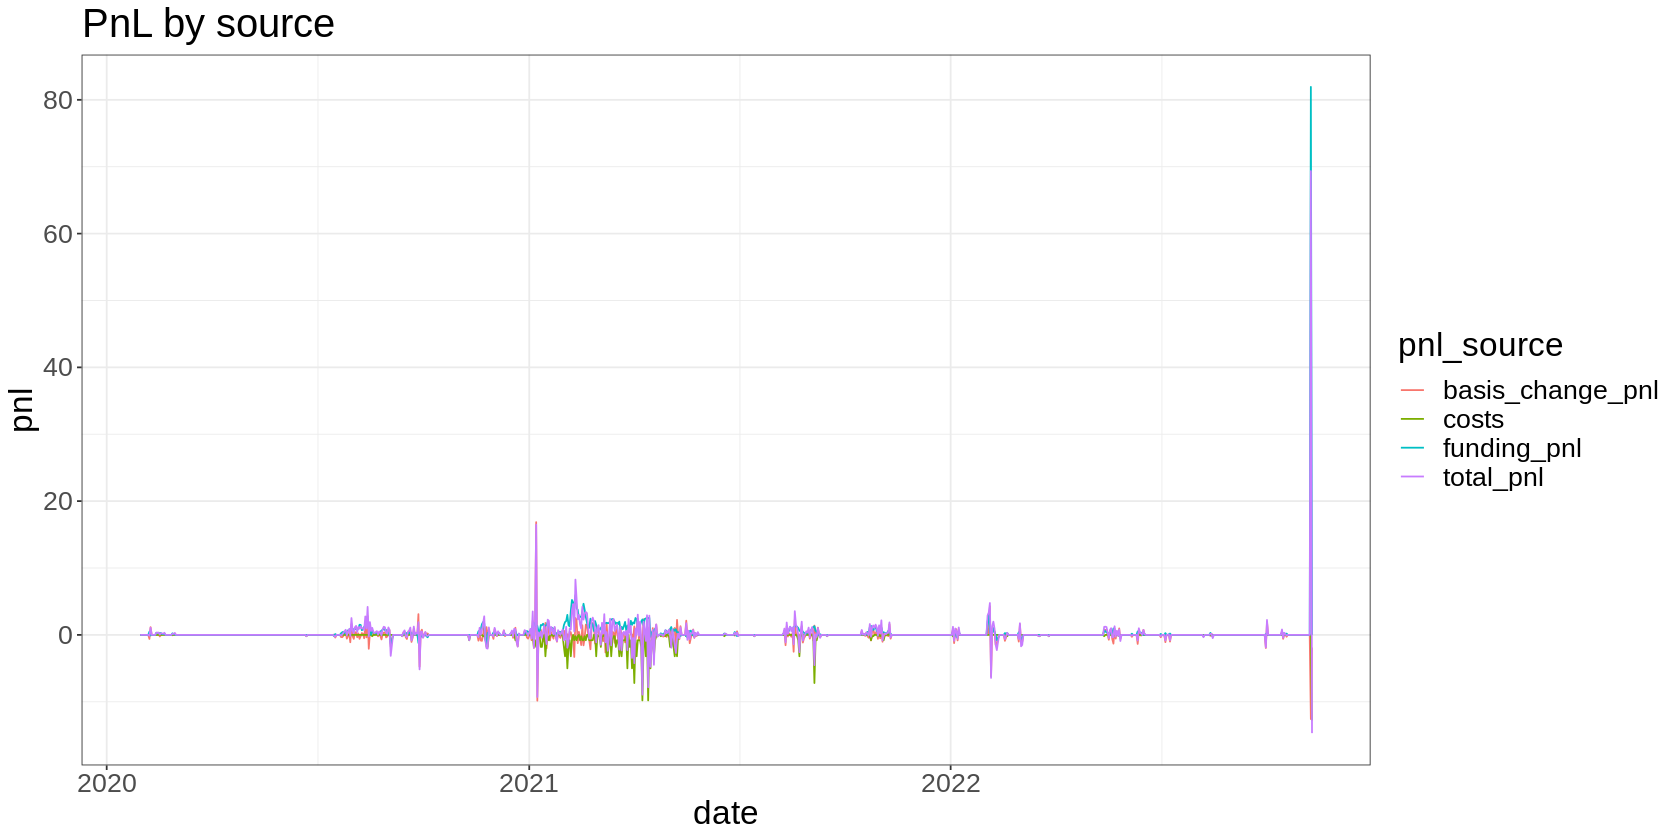

In [61]:
results_df %>%
  select(date, basis_change_pnl, funding_pnl, costs, total_pnl) %>%
  pivot_longer(-date, names_to = "pnl_source", values_to = "pnl") %>%
  ggplot(aes(x = date, y = pnl, colour = pnl_source)) +
    geom_line() +
    labs(title = "PnL by source")

Observe that most of the return comes from funding (purple line tracks the blue line, mostly). 

Next we'll plot cumulative pnl to each source, as well as total pnl to the strategy:

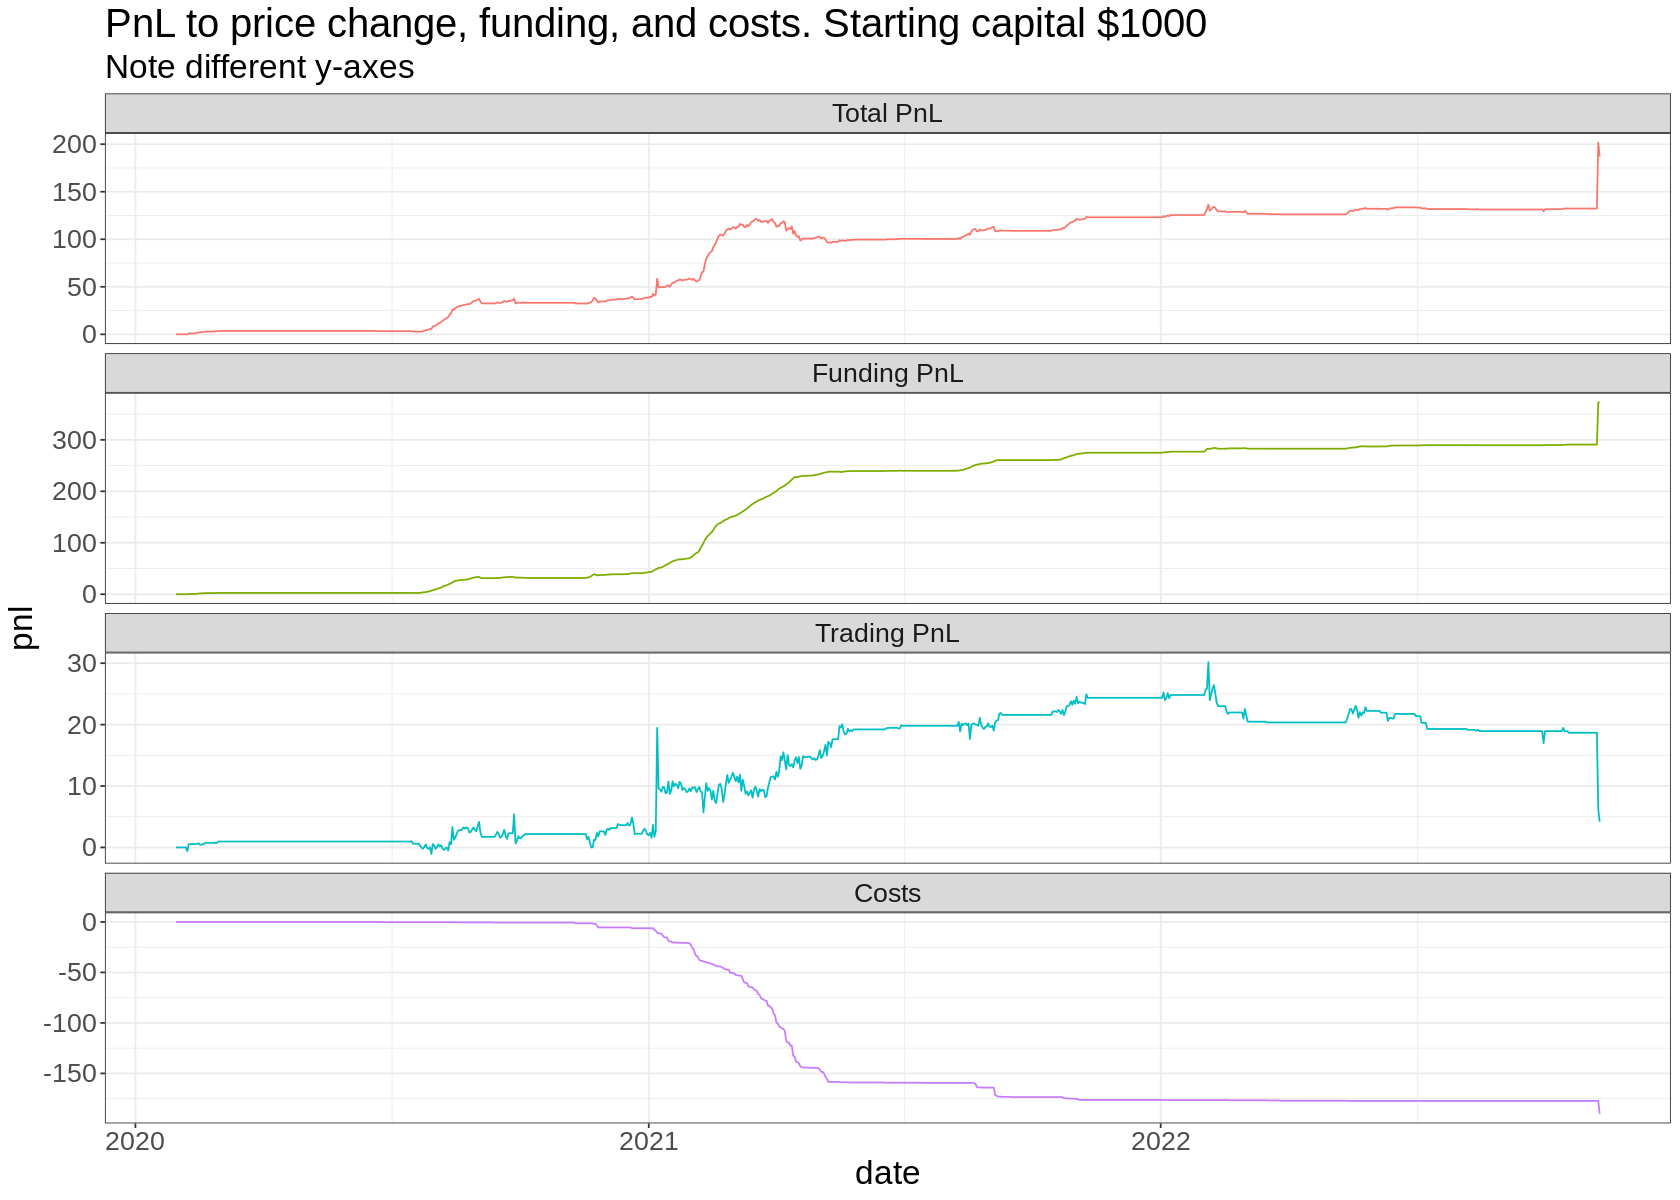

In [62]:
options(repr.plot.width = 14, repr.plot.height=10)

results_df %>%
  mutate(
    `Trading PnL` = cumsum(basis_change_pnl),
    `Funding PnL` = cumsum(funding_pnl),
    Costs = cumsum(costs),
    `Total PnL` = cumsum(total_pnl)
  ) %>%
  select(date, `Trading PnL`, `Funding PnL`, Costs, `Total PnL`) %>%
  pivot_longer(-date, names_to = "pnl_source", values_to = "pnl") %>%
  mutate(pnl_source = factor(pnl_source, levels = c("Total PnL", "Funding PnL", "Trading PnL", "Costs"))) %>%
  ggplot(aes(x = date, y = pnl, colour = pnl_source)) +
    geom_line() +
    facet_wrap(~pnl_source, scales = "free_y", ncol = 1) +
    labs(
      title = glue("PnL to price change, funding, and costs. Starting capital ${capital}"),
      subtitle = "Note different y-axes"
    ) +
    theme(legend.position = "none") 

options(repr.plot.width = 14, repr.plot.height=7)

Calculate some performance metrics:

In [63]:
results_df %>%
  summarise(
    Ann.Return = mean(total_pnl)*365/capital,
    Ann.Vol = sd(total_pnl/capital)*sqrt(365),
    Ann.Sharpe = Ann.Return/Ann.Vol
  ) %>%
  mutate(across(.cols = everything(), .fns = ~ round(.x, 3)))

Ann.Return,Ann.Vol,Ann.Sharpe
<dbl>,<dbl>,<dbl>
0.067,0.048,1.407


### Summary of strategy rules and simulation assumptions

**Rules:**
- Your universe consists of the perps for which there is an equivalent spot market, and which have an average 5-day volume of at least $1,000,000 USD.
- For each perpetual, calculate the mean funding over the last four days.
- 7x this value is your funding forecast for the next 7 days. 
- Rank your universe of perpetuals according to their funding forecast. 
- Allocate one-fifth of your total allocation to each of the top-5 spreads by forecast funding rate. 
- Check forecasts and update positions daily. 

**Simulation assumptions and where they might break down:**
- 0.1% cost per trade. This is a reasonable assumption:
  - for moderately liquid coins like the ones in our universe
  - and assuming you can execute with only a small amount of market impact on average
  - and assuming you are on the second or third FTX commission tier
- You trade at the closing price of each day, where each day ends at midnight UTC. This is unlikely to make much difference and the strategy should be robust to trading time.

**A "bettter" rule**
- In reality, it wouldn't make sense to trade out of a positive expected value spread and into a new one just because the new one was slightly more positive than the old one. The costs of doing so are significant in proportion to the size of the edge. 
- Instead, use judgement and err on the side of sticking with existing positions until they're predicted to be negative EV, or another spread is predicted to be *significantly* higher EV.

### How could the strategy be improved?

The strategy already does quite well. However, some ideas for improving the strategy include:
- Using a better model for the funding prediction. This could incorporate intra-day and intra-week seasonality of the basis (if it existed), as well as explicitly modeling long-memory effects and jump effects/reversion from extreme values. 
- Getting really good at spread execution. 
- Optimising trading around intra-day seasonality of trading volume.
- Experimenting with the universe cutoff criteria, the number of perpetuals in the universe, and the funding forecast threshold.

Of the above, I would focus on items 2 and 3. That stuff will likely make an immediate difference and you'll learn a lot from doing it. 


